In [55]:
import pandas as pd  # requires: pip install pandas
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt  # requires: pip install matplotlib
import numpy as np
from sklearn.metrics import mean_squared_error

# Initialize the ChronosPipeline
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

# Read the simulated GBM data
df_gbm = pd.read_csv('simulated_gbm_paths_with_increasing_noise.csv')

# Get unique combinations of mu, sigma, initial_noise_factor, and final_noise_factor
combinations = df_gbm[['mu', 'sigma', 'initial_noise_factor', 'final_noise_factor']].drop_duplicates().values

# List of different prediction lengths to try
prediction_lengths = [10, 20, 30]

# Dictionary to store MSE for each combination and prediction length
mse_summary = {}

# Sample size for the combinations to plot
sample_size = 20
np.random.seed(42)
# Convert combinations to tuples for easy comparison
combinations_as_tuples = [tuple(comb) for comb in combinations]

# Convert list of tuples to a NumPy array for sampling
combinations_as_array = np.array(combinations_as_tuples, dtype=object)

# Sample unique combinations for plotting
sampled_combinations = set(tuple(comb) for comb in combinations_as_array[np.random.choice(combinations_as_array.shape[0], size=sample_size, replace=False)])



D:\anaconda\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [57]:
sampled_combinations

{(-0.9, 0.2, 1.0, 2.0),
 (-0.8, 0.3, 1.5, 2.5),
 (-0.6, 0.3, 1.0, 2.5),
 (-0.5, 0.4, 1.0, 2.5),
 (-0.4, 0.3, 1.0, 2.5),
 (-0.3, 0.3, 1.5, 2.5),
 (-0.2, 0.4, 1.0, 2.0),
 (-0.1, 0.4, 1.0, 2.5),
 (0.0, 0.4, 1.0, 2.0),
 (0.1, 0.3, 1.5, 2.5),
 (0.3, 0.1, 1.5, 2.0),
 (0.3, 0.5, 1.5, 2.5),
 (0.4, 0.5, 1.5, 2.0),
 (0.5, 0.1, 1.0, 2.0),
 (0.5, 0.1, 1.5, 2.0),
 (0.5, 0.3, 1.0, 2.5),
 (0.7, 0.3, 1.5, 2.0),
 (0.8, 0.1, 1.0, 2.5),
 (0.8, 0.2, 1.5, 2.5),
 (0.9, 0.1, 1.0, 2.0)}

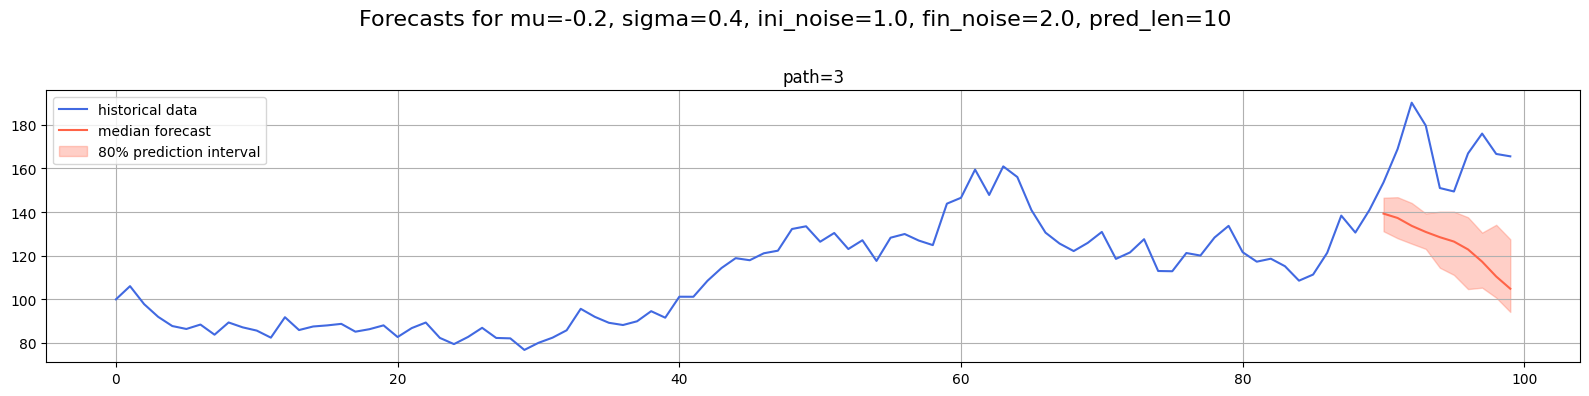

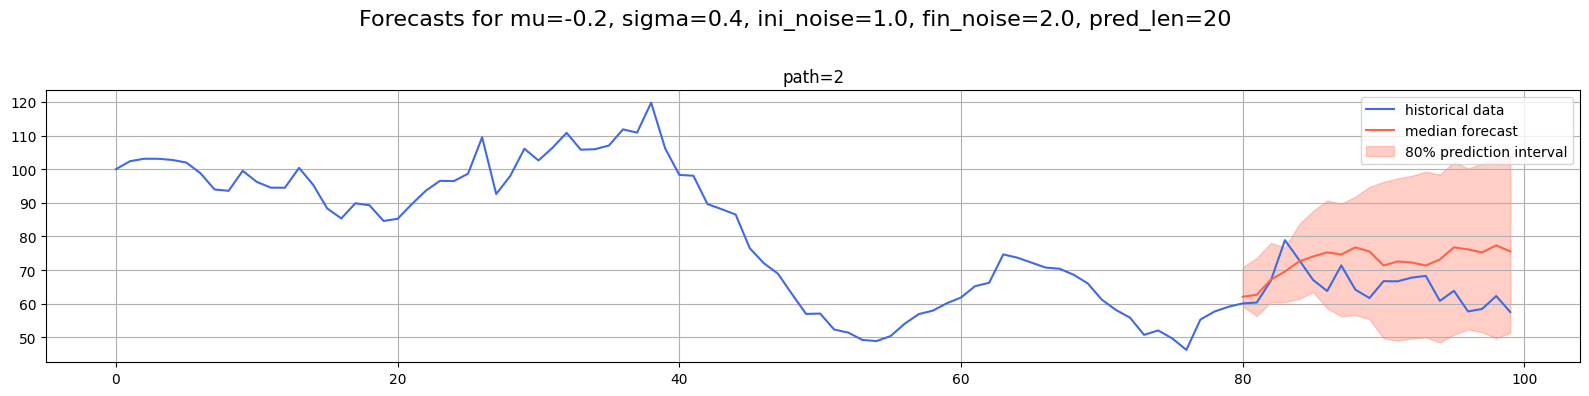

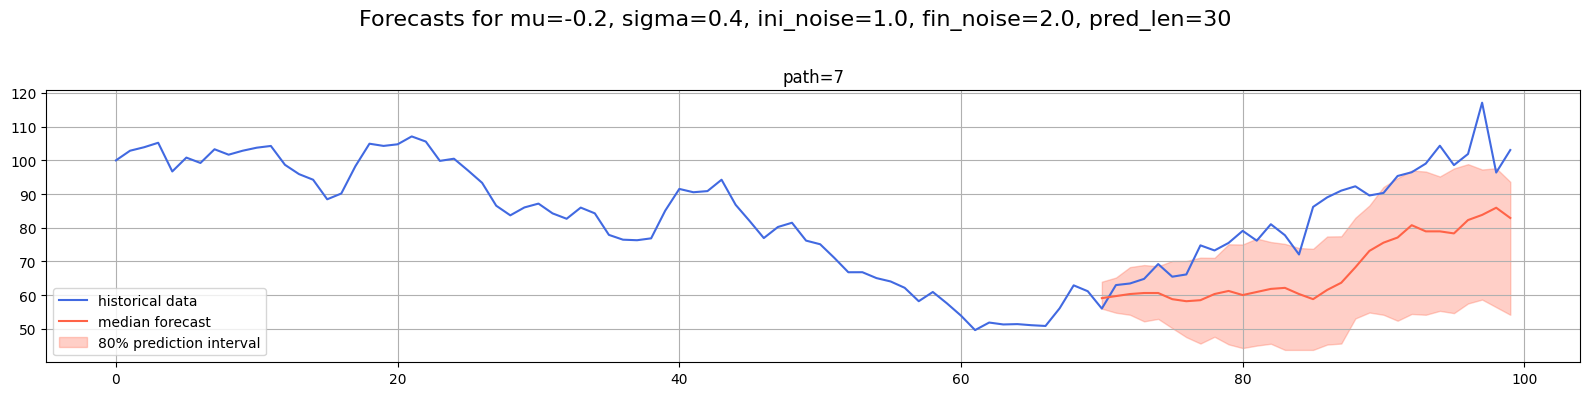

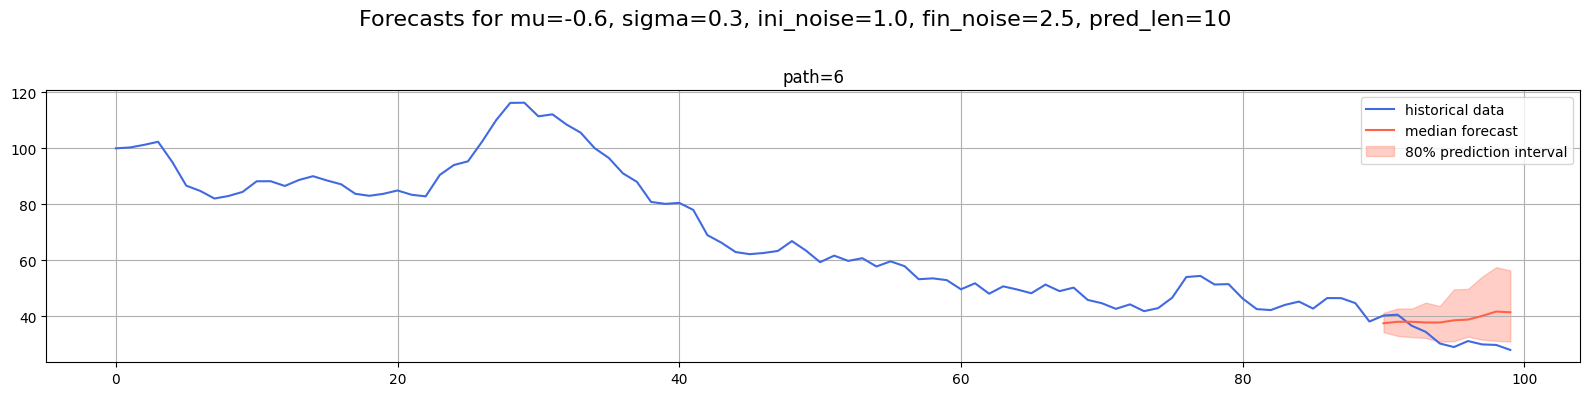

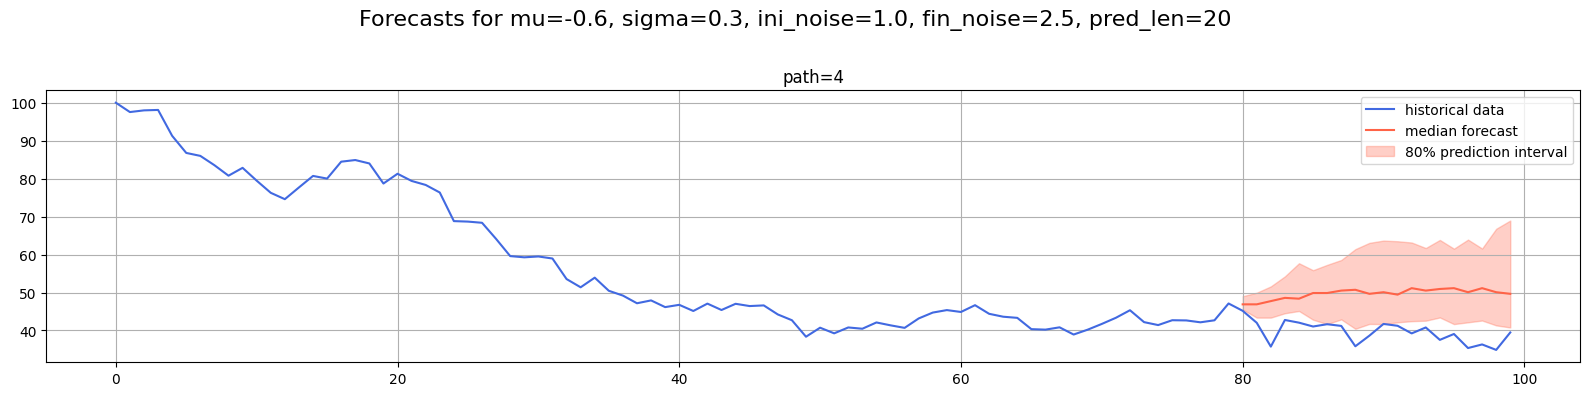

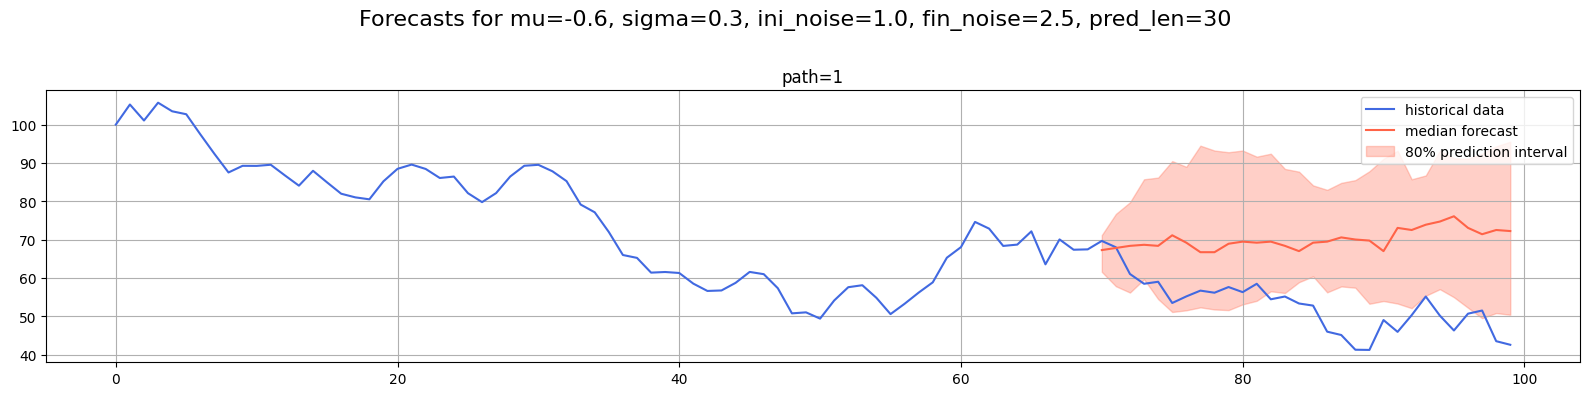

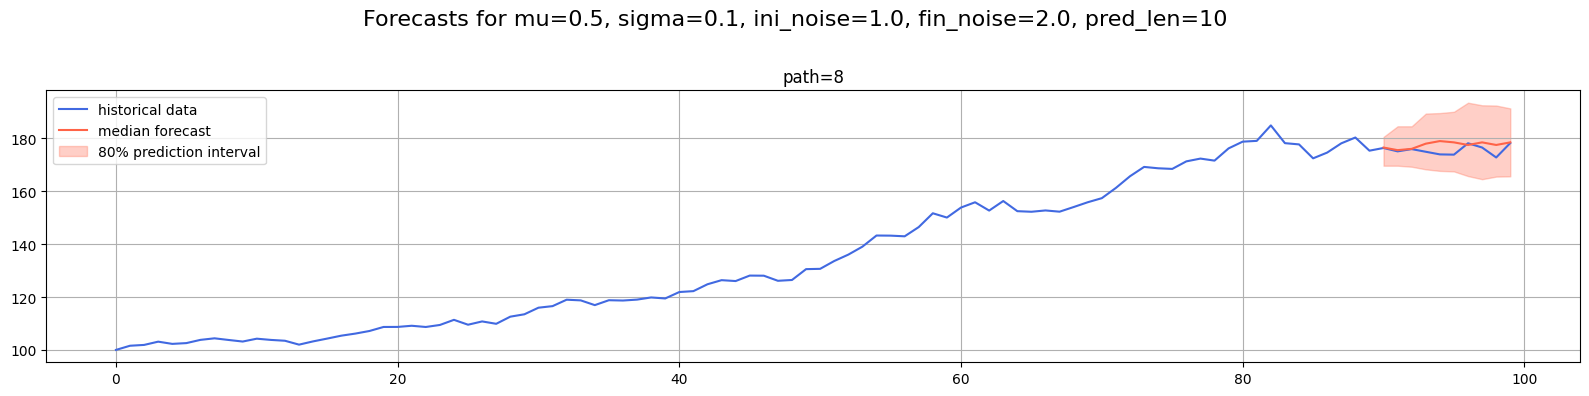

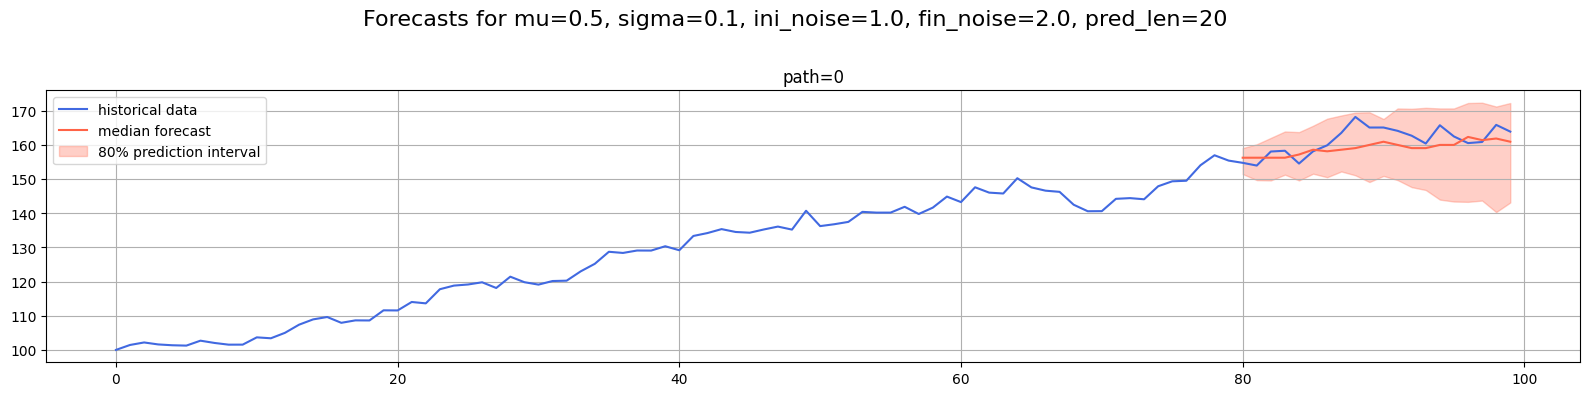

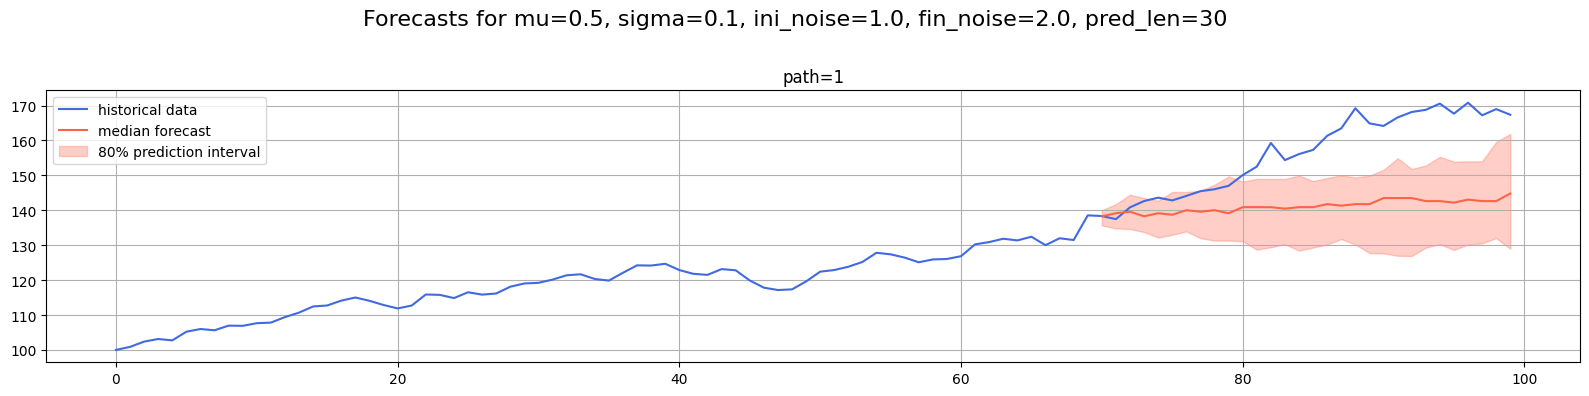

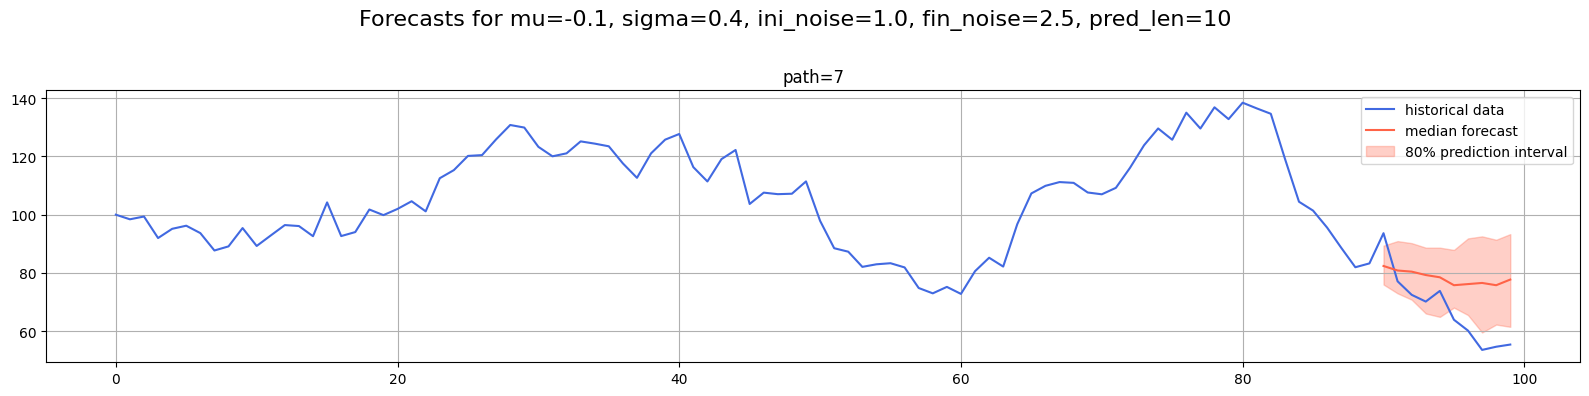

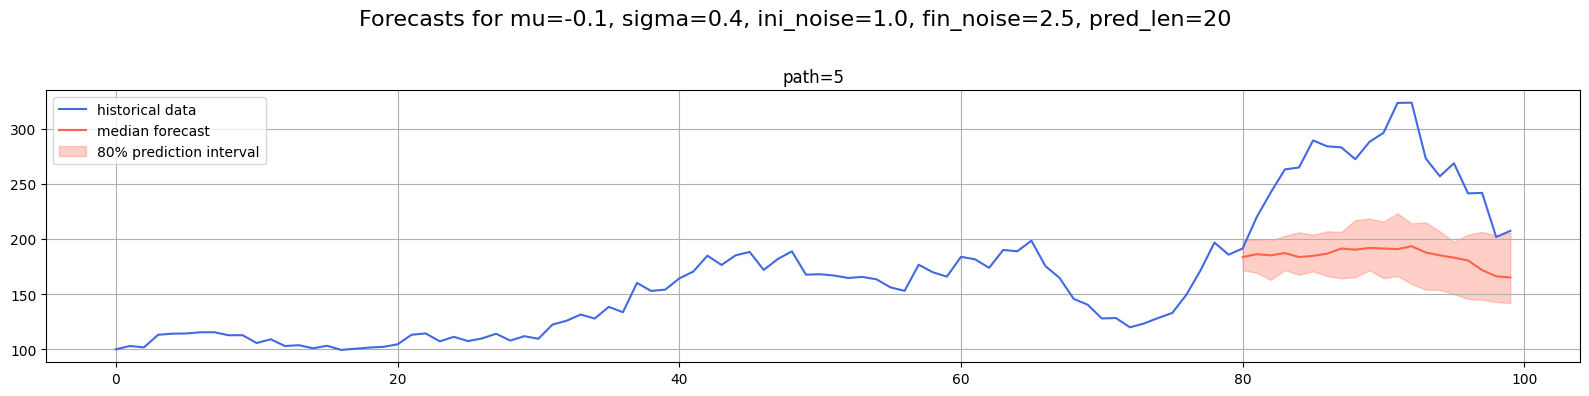

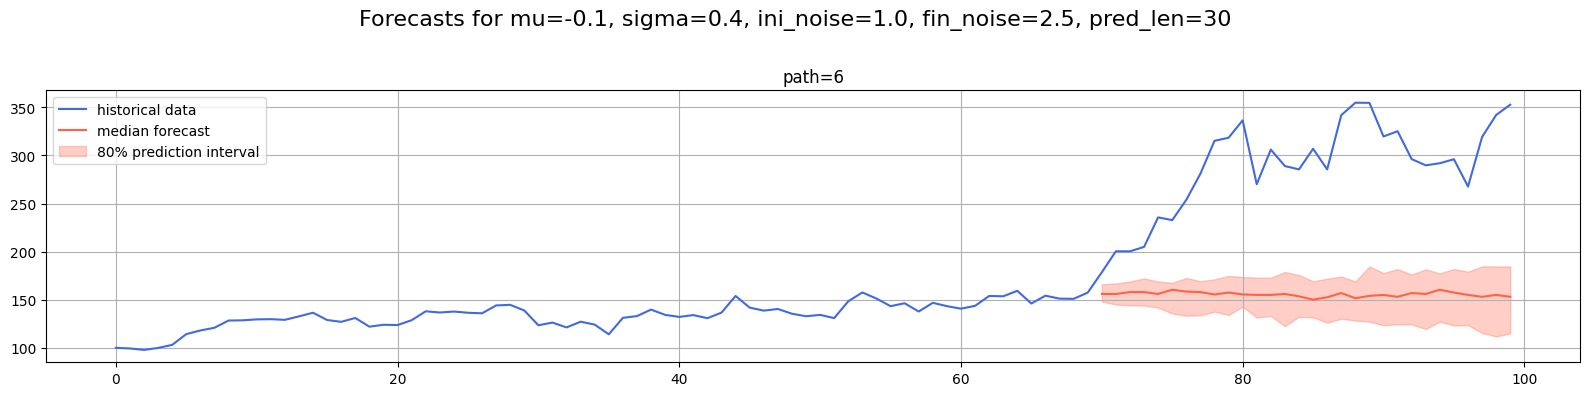

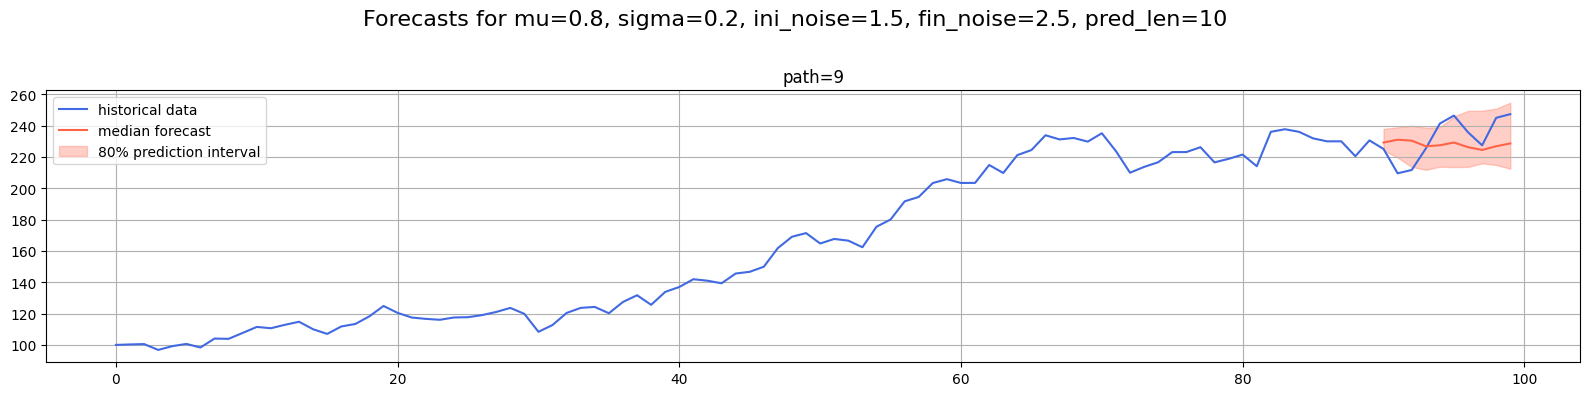

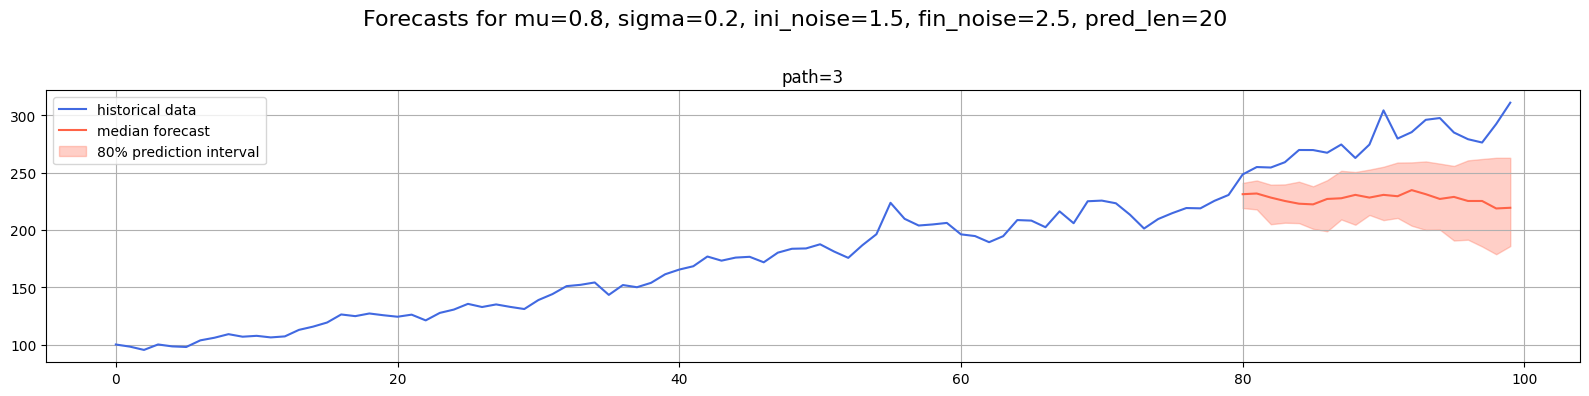

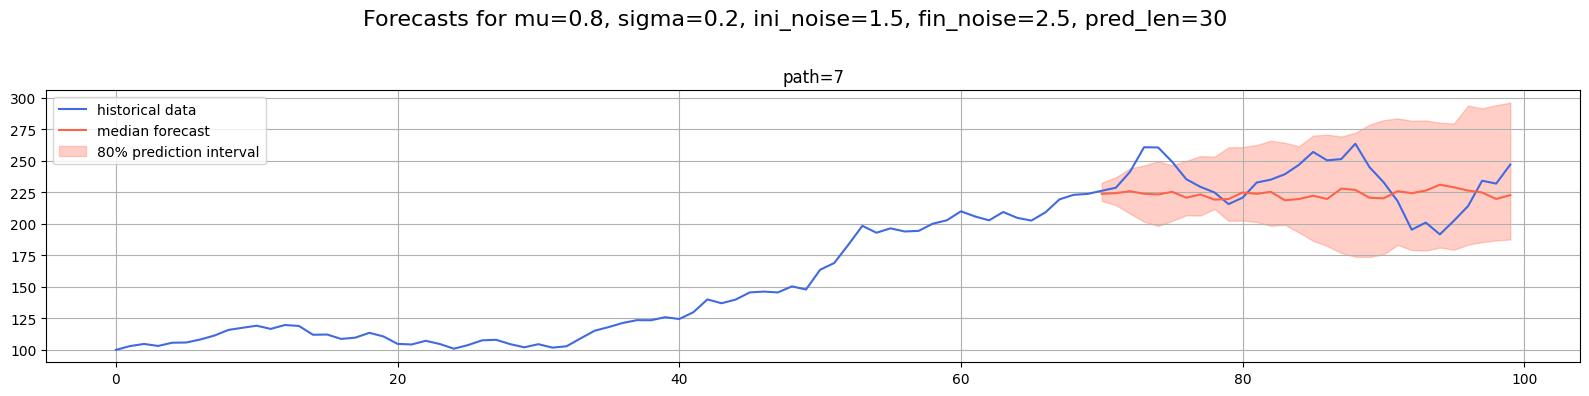

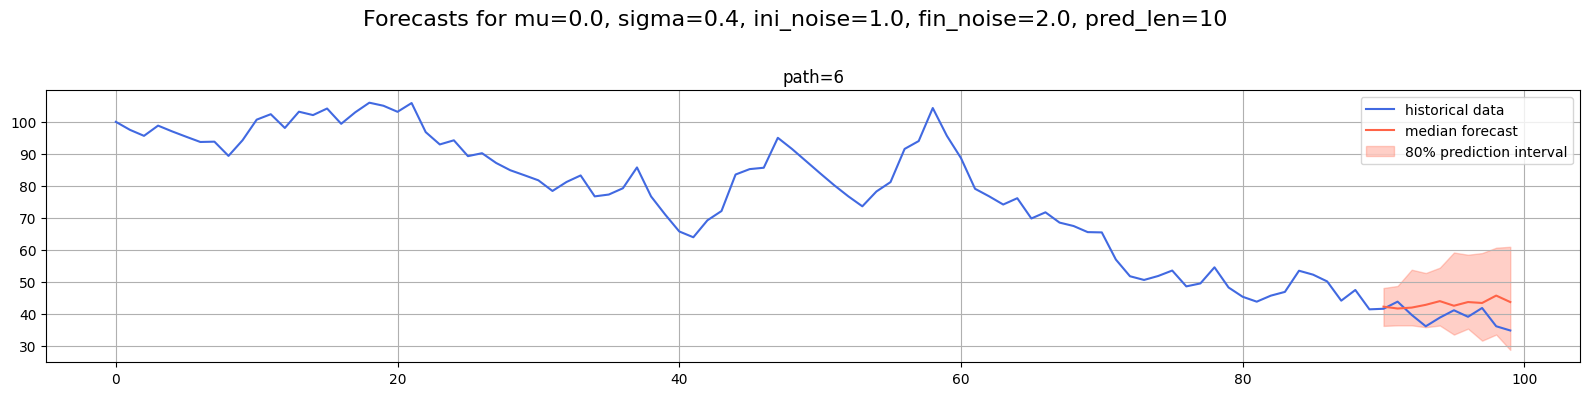

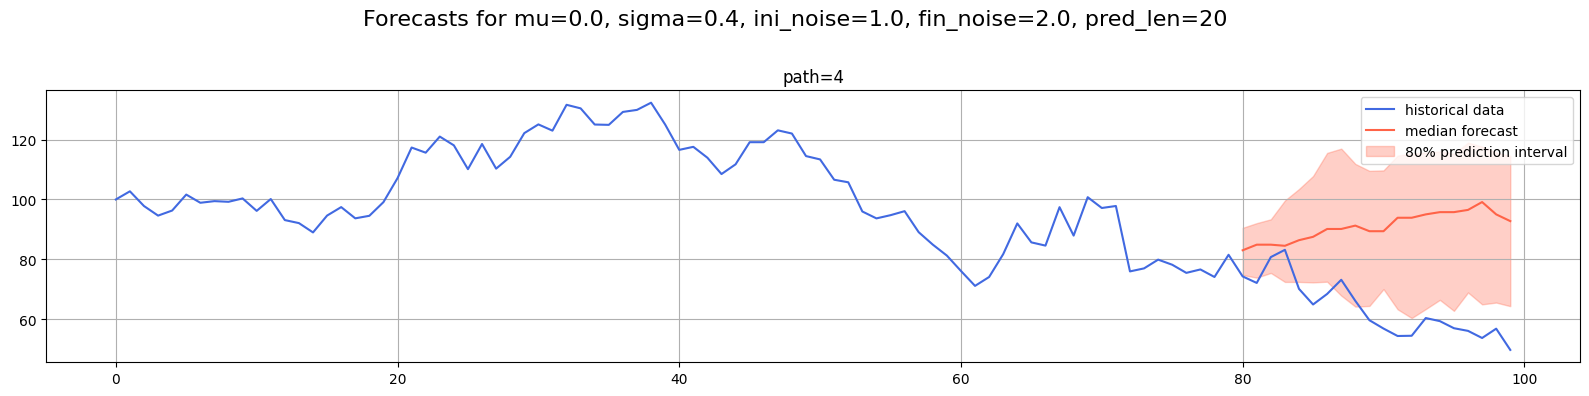

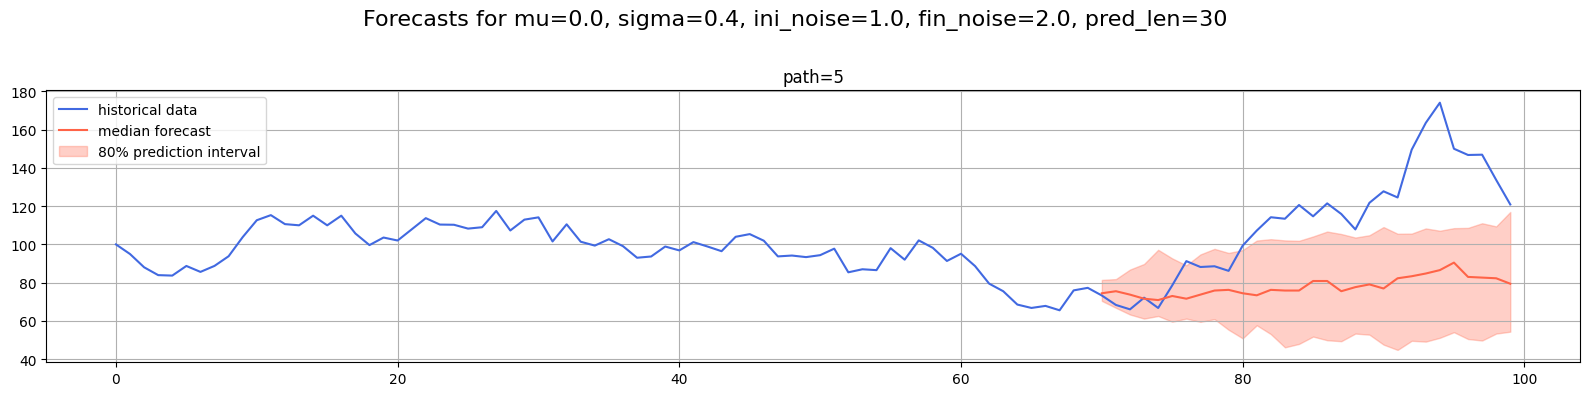

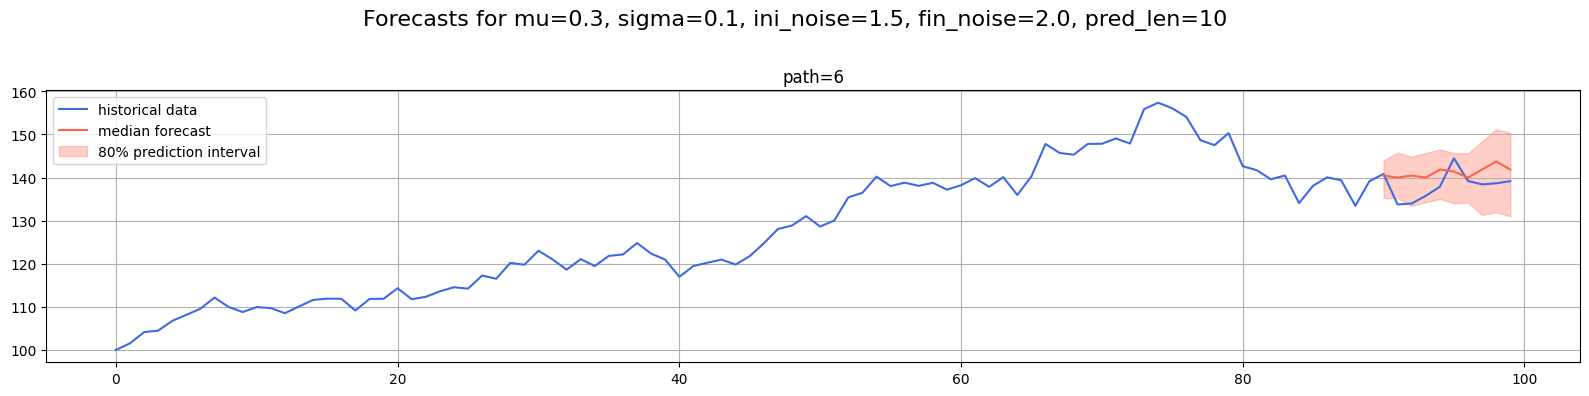

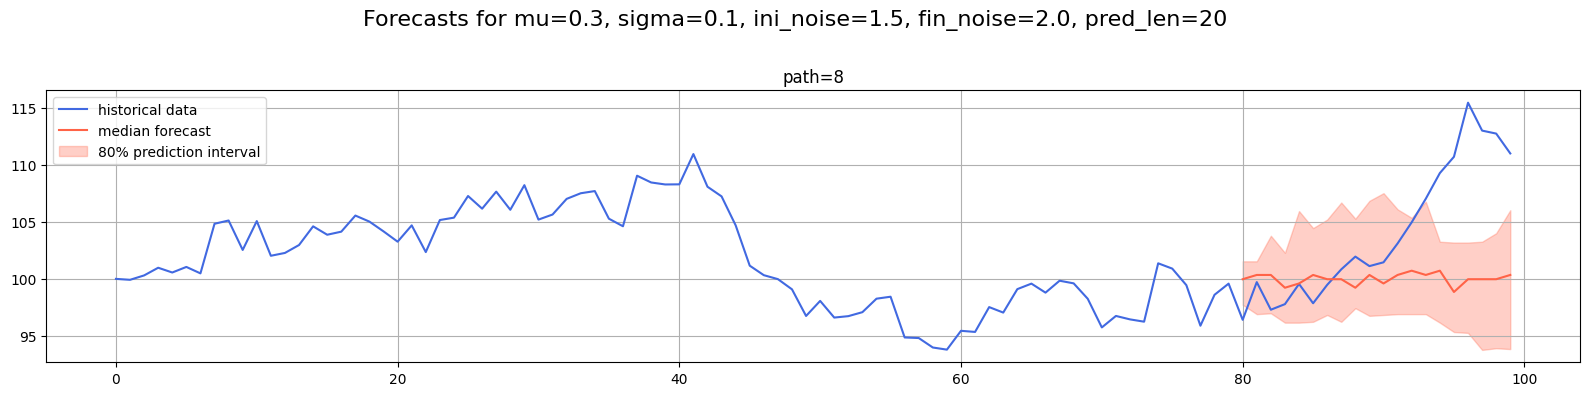

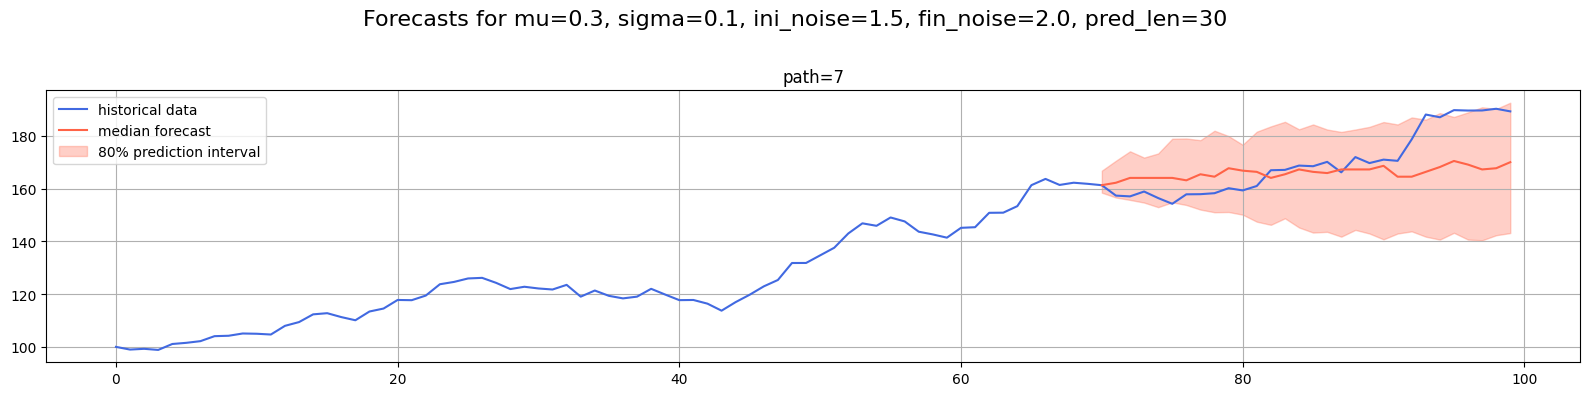

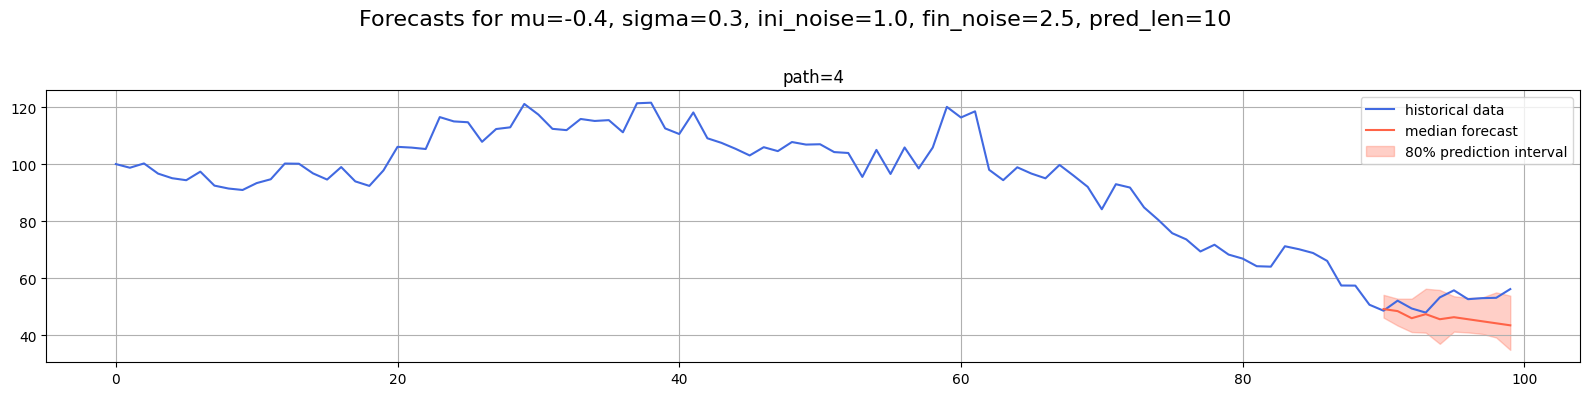

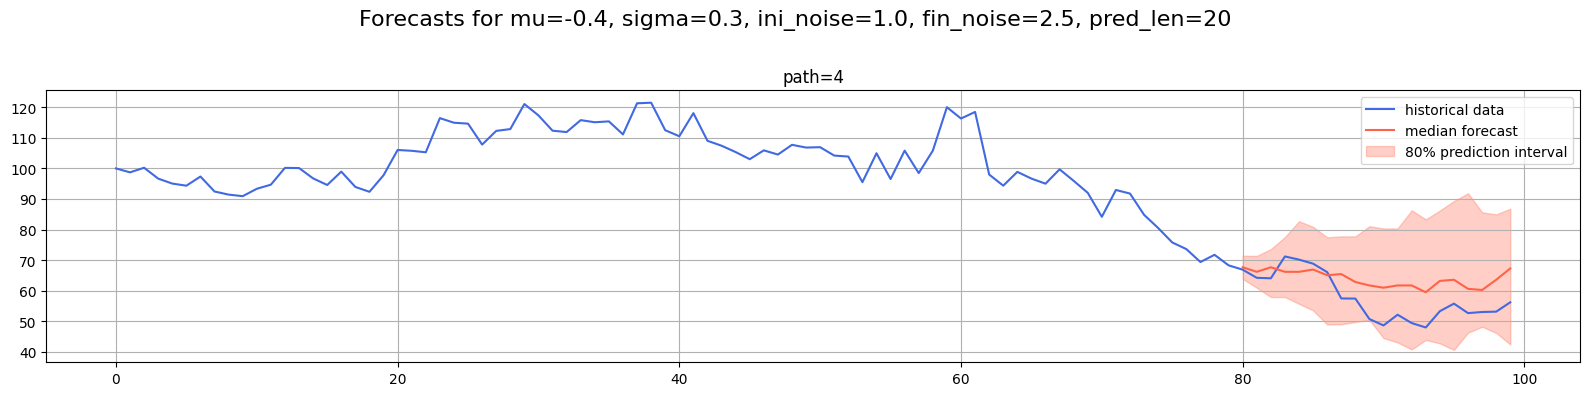

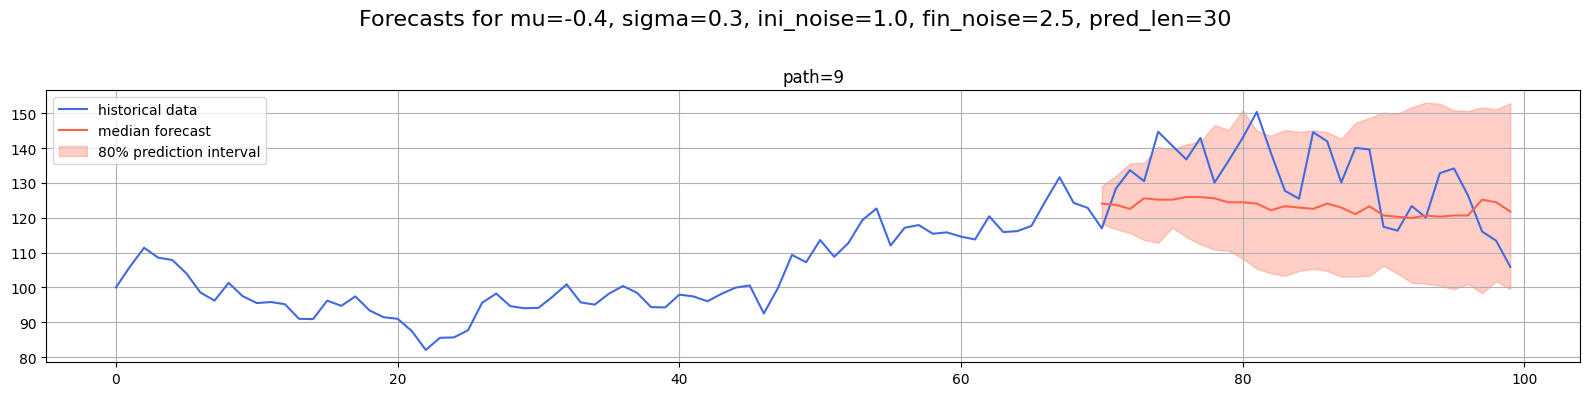

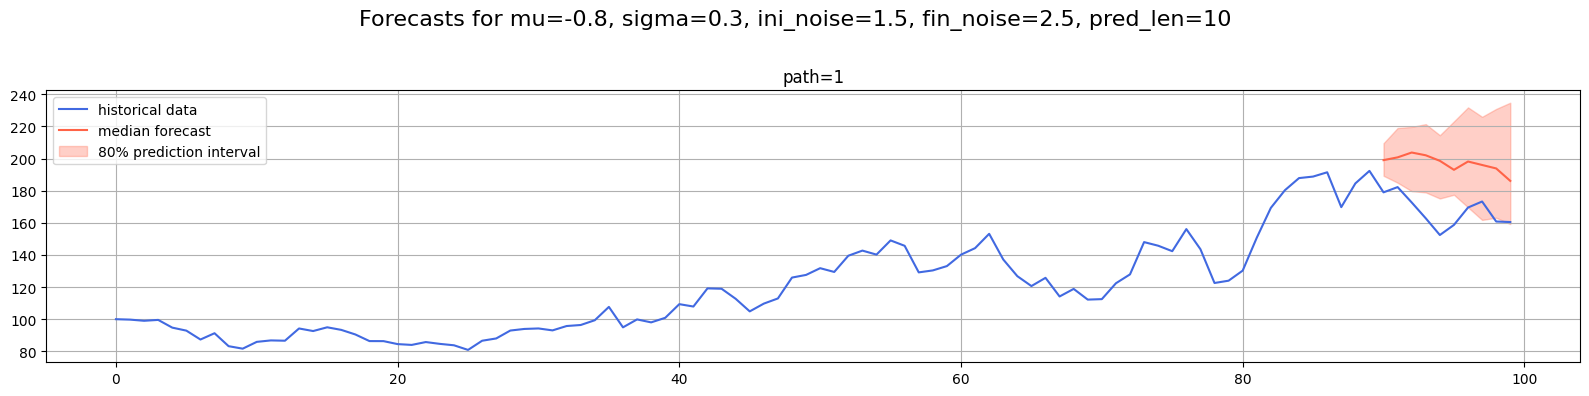

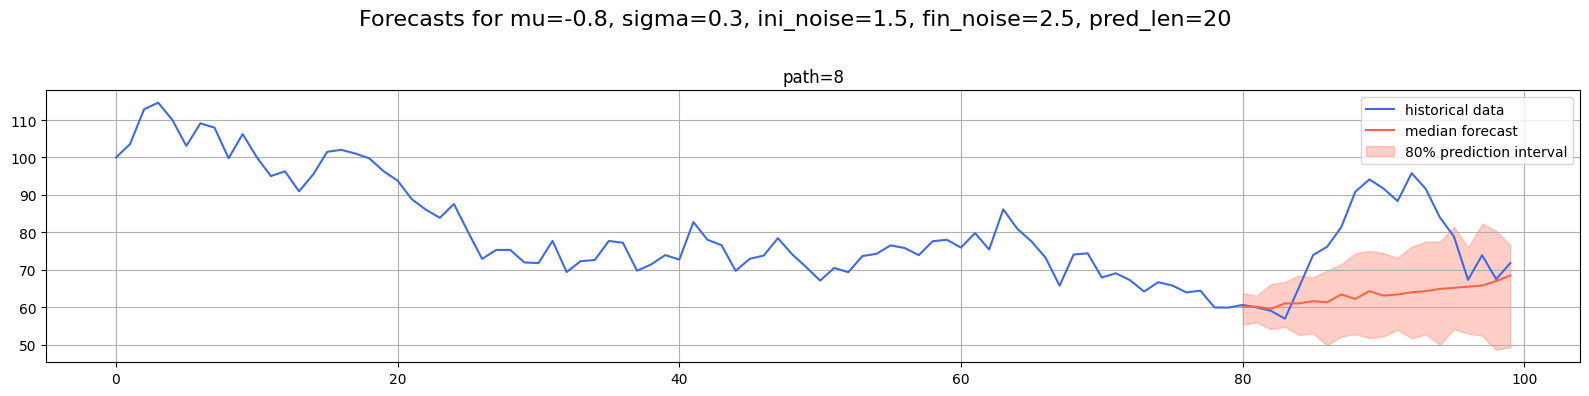

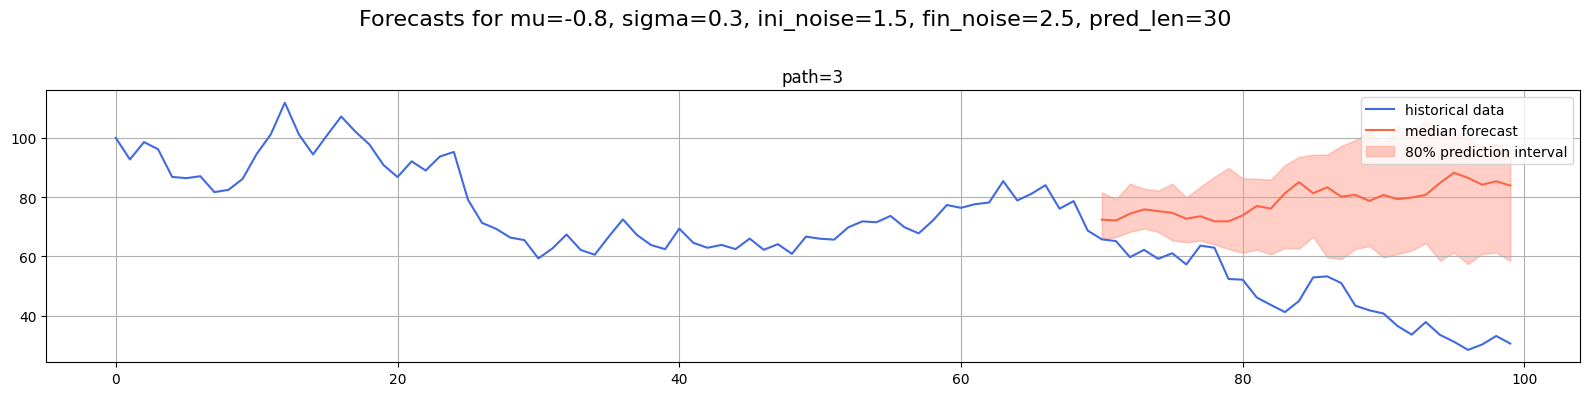

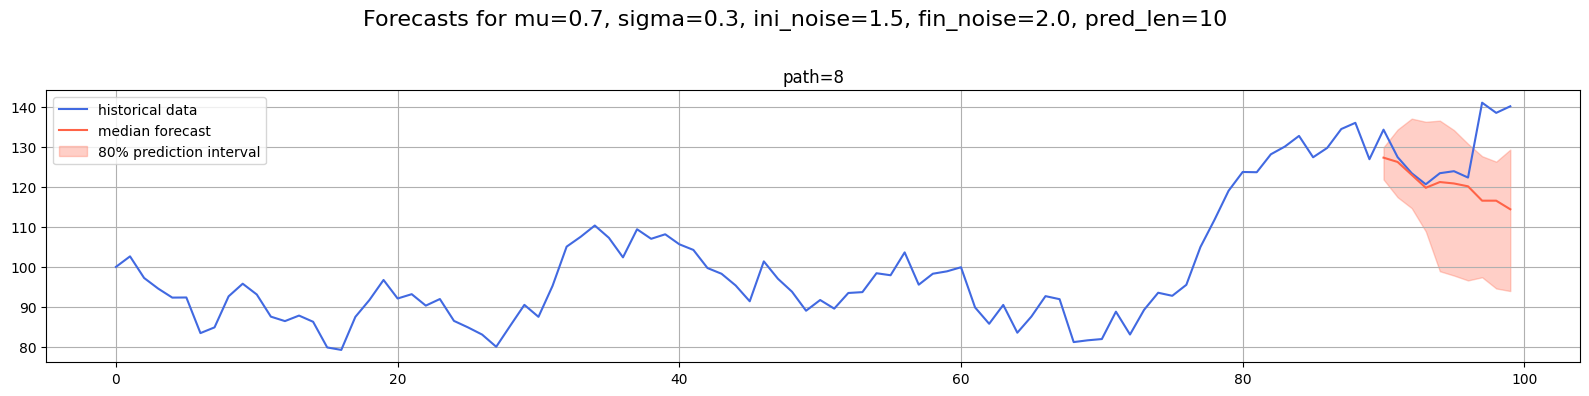

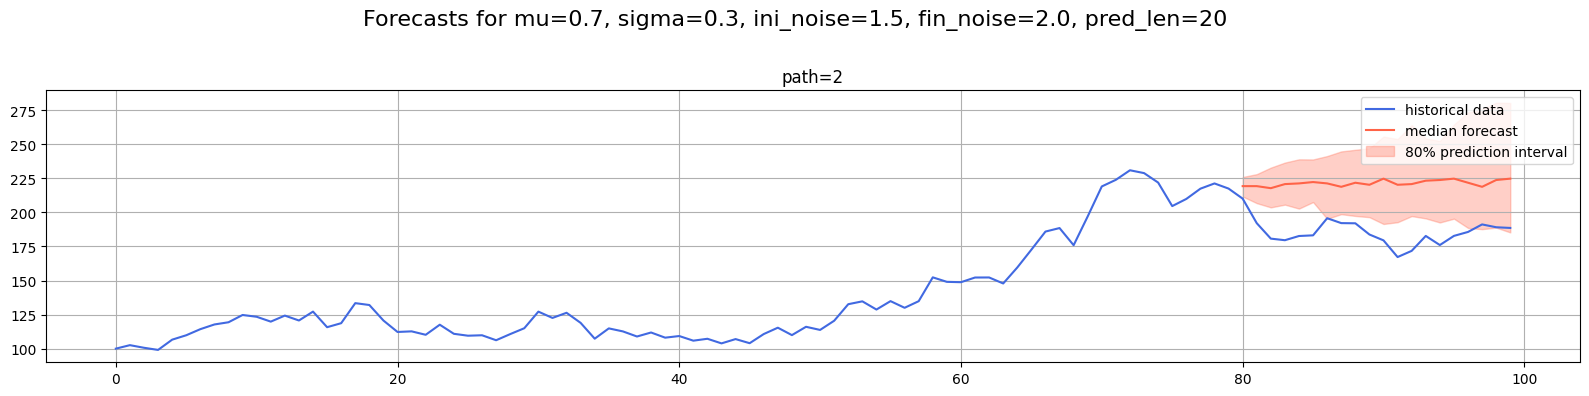

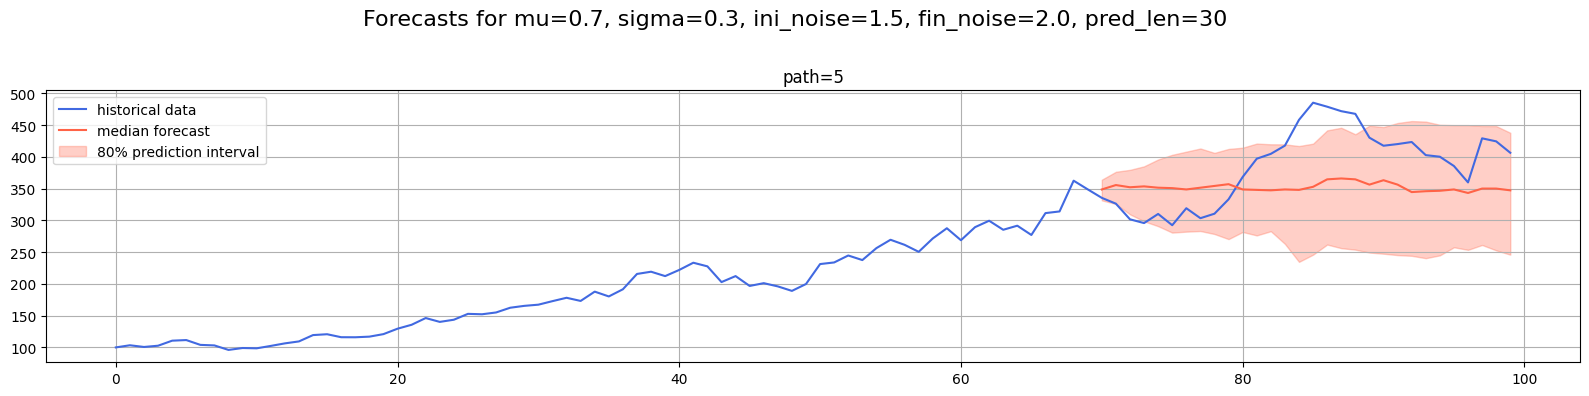

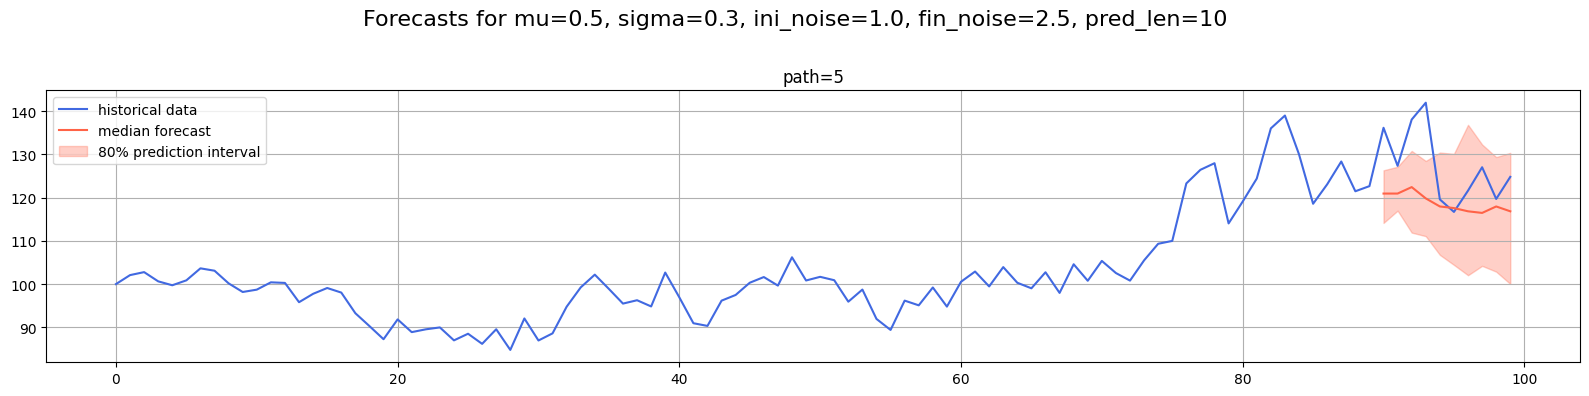

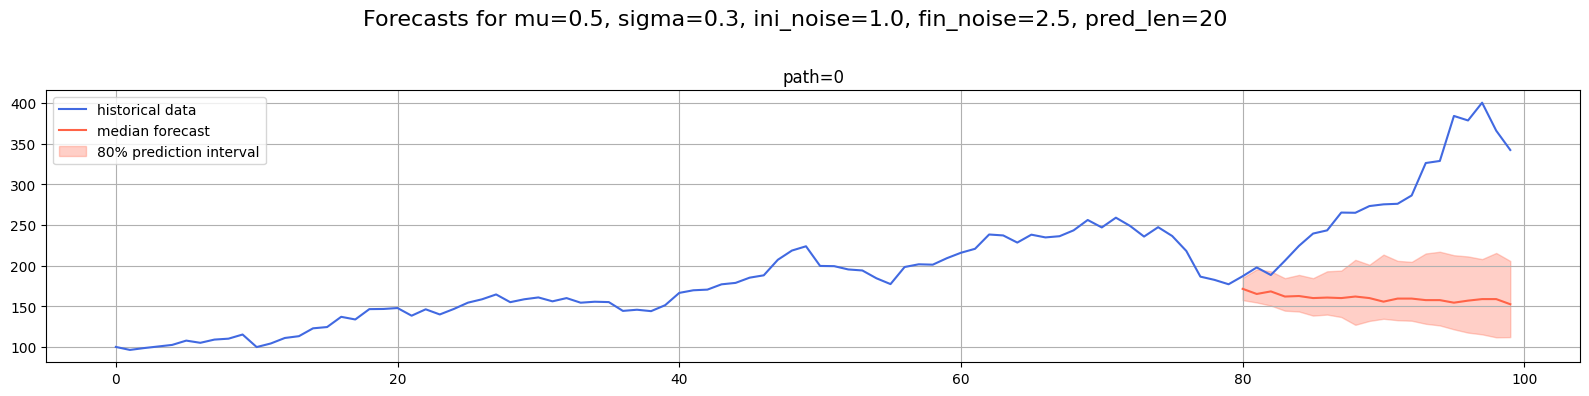

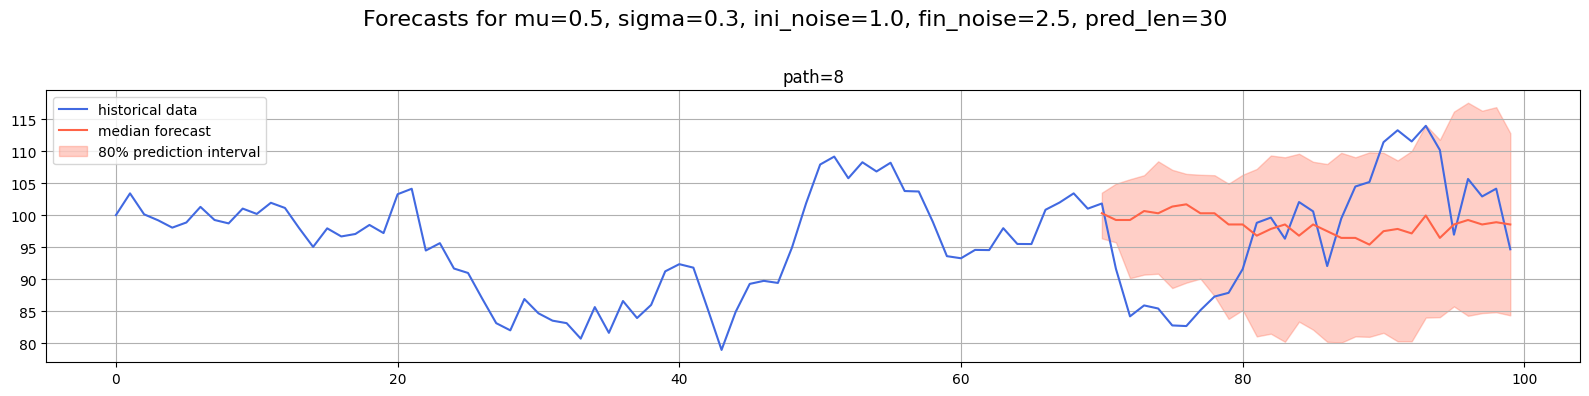

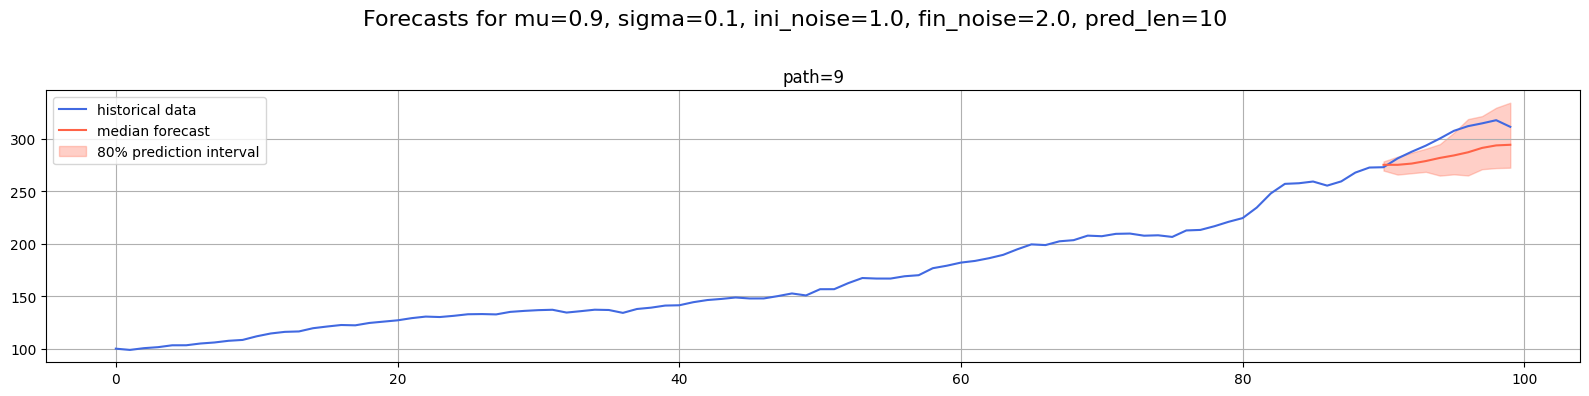

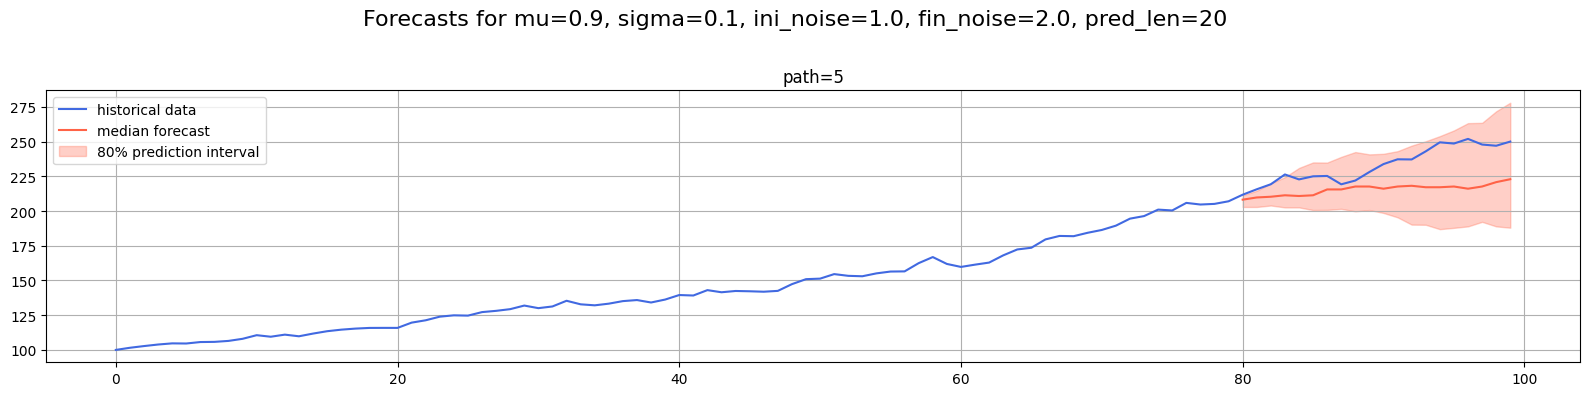

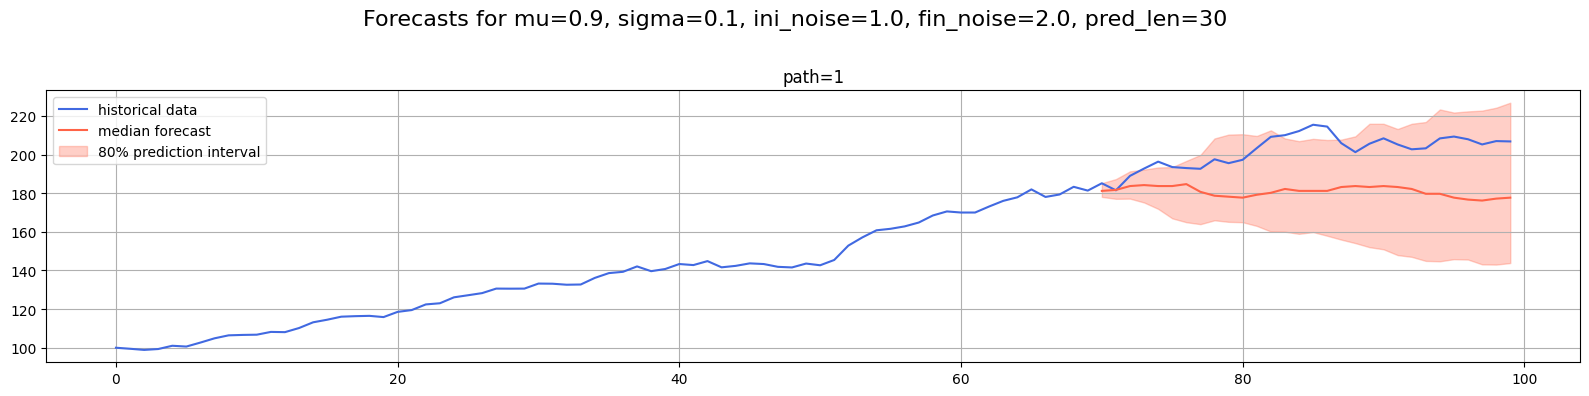

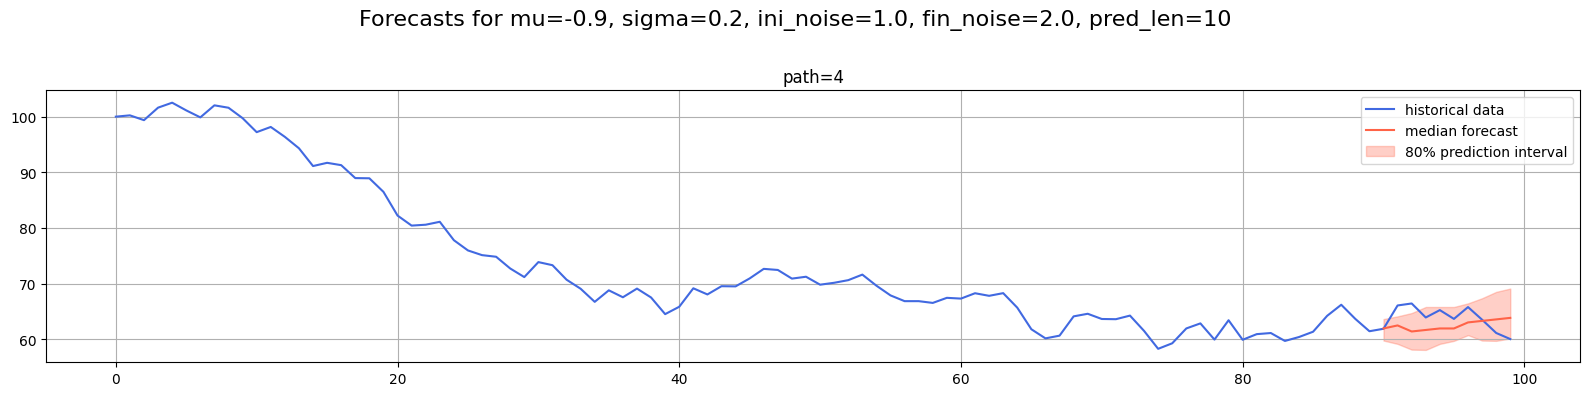

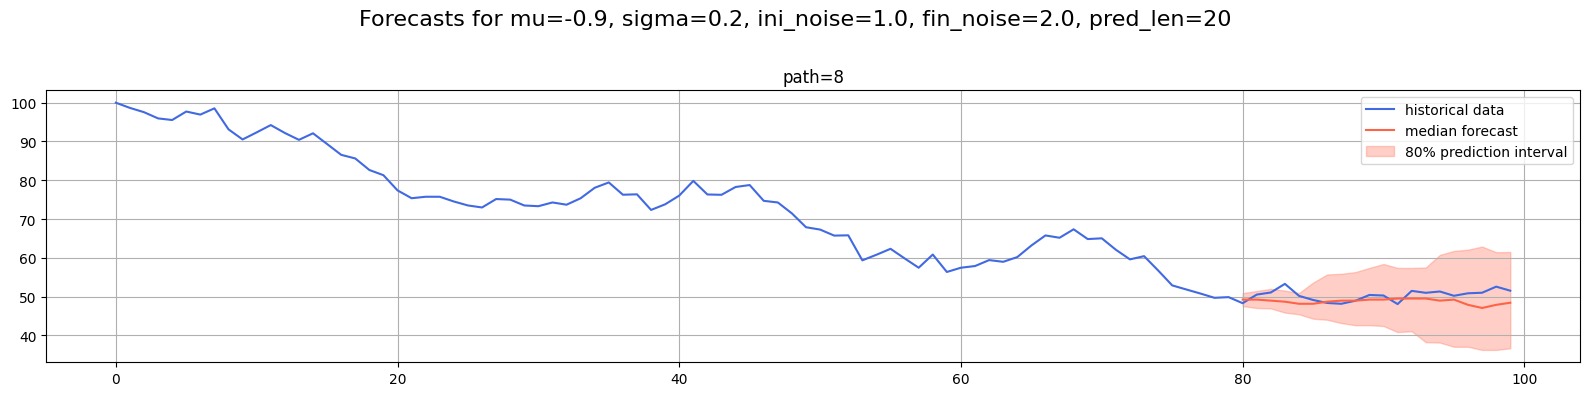

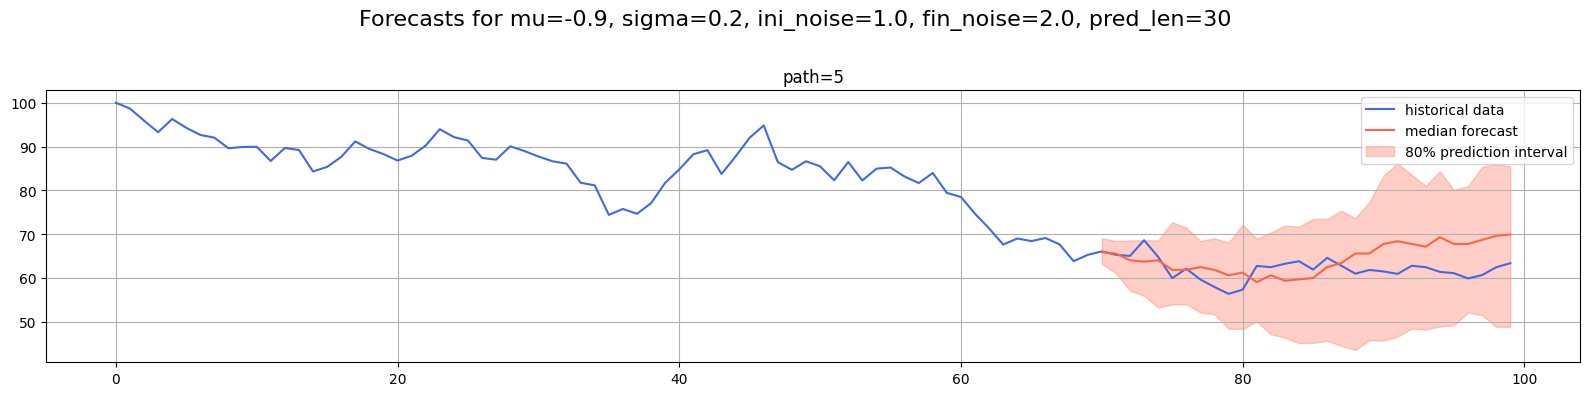

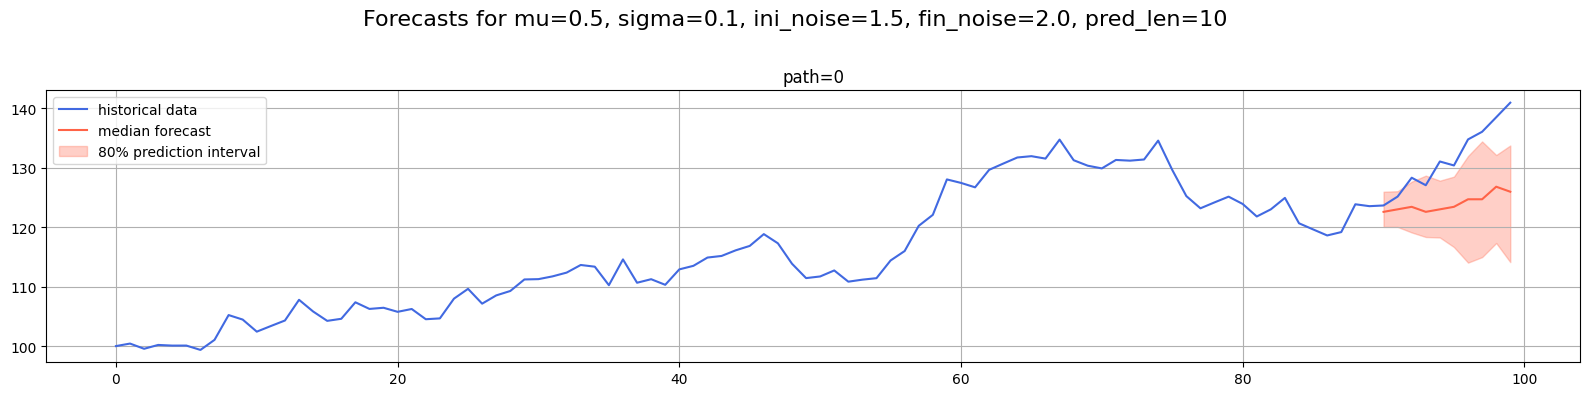

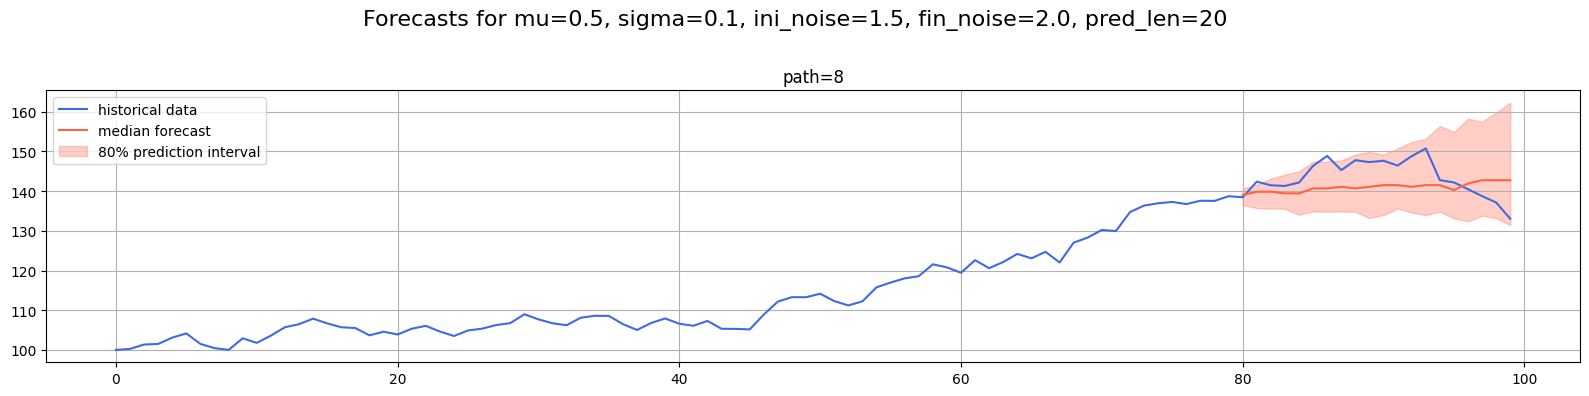

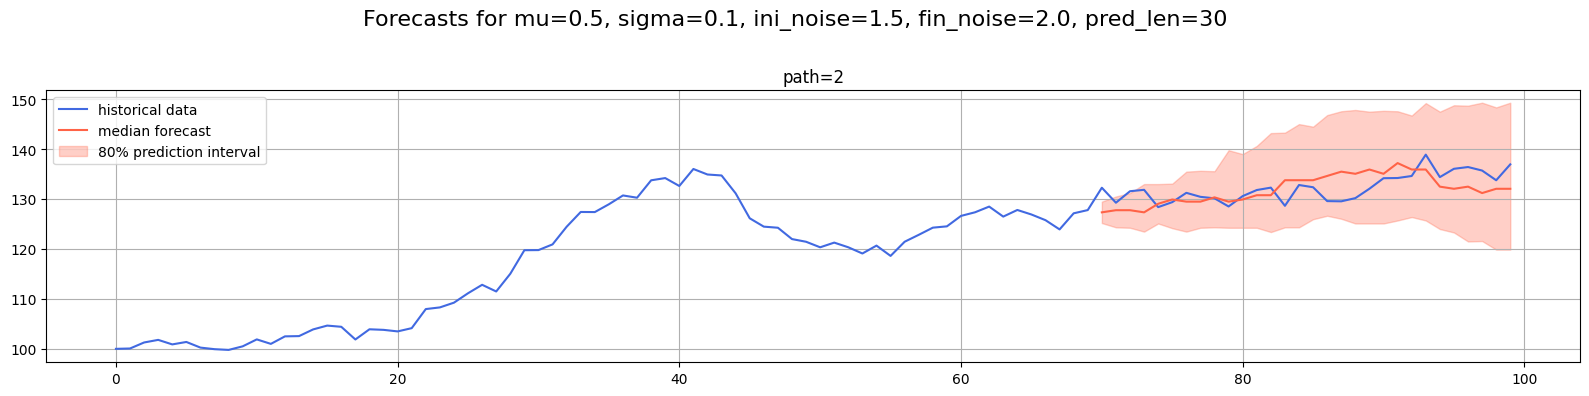

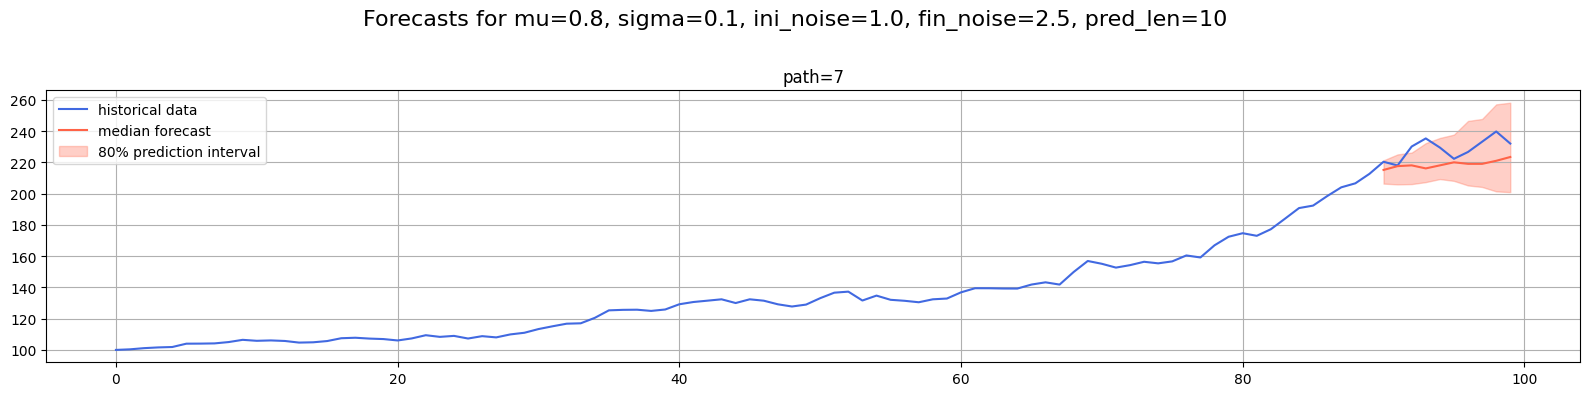

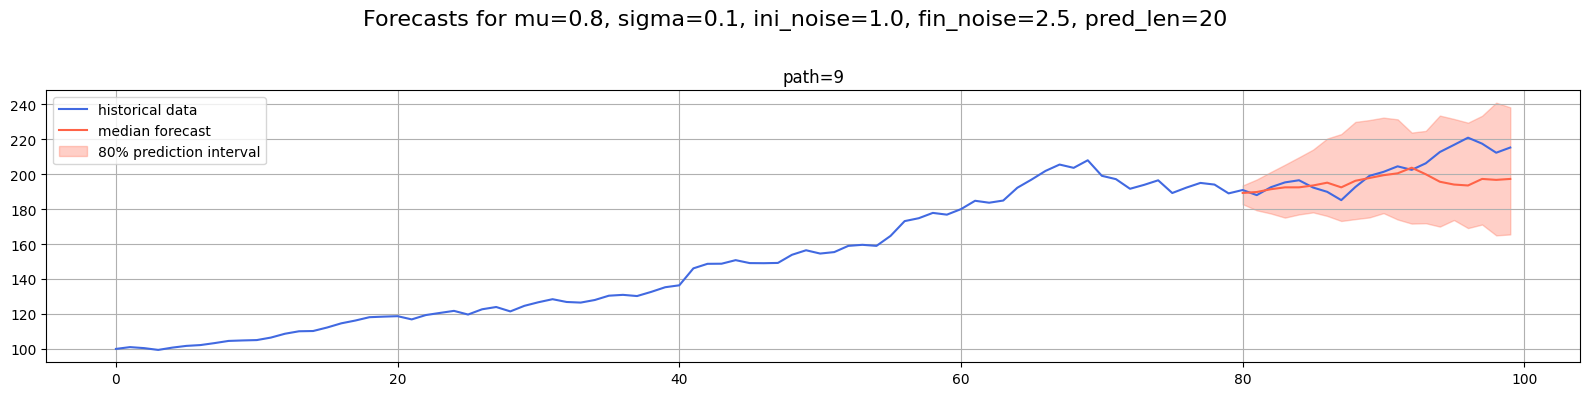

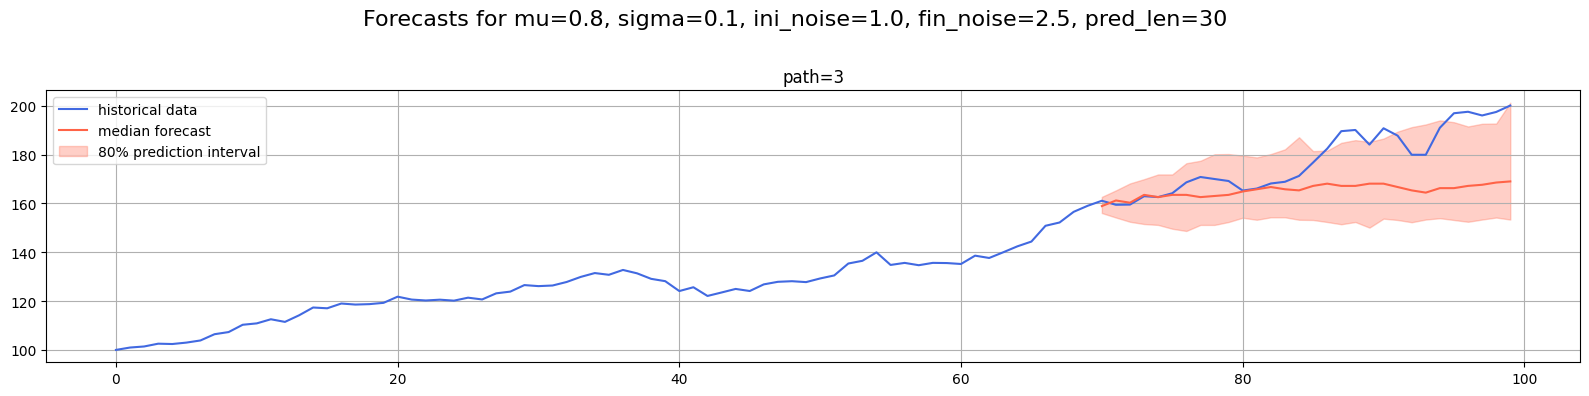

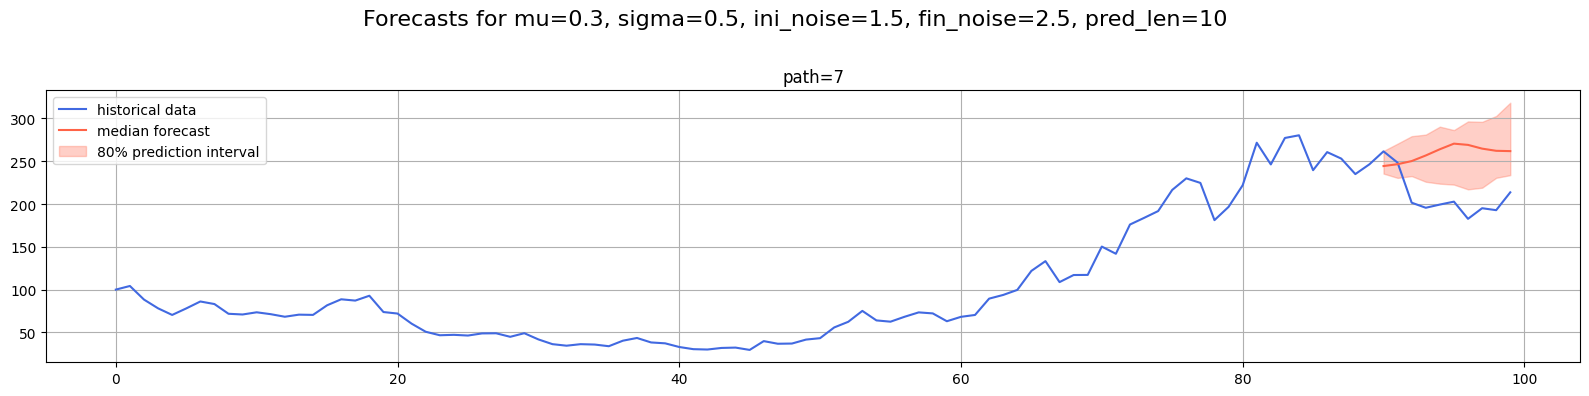

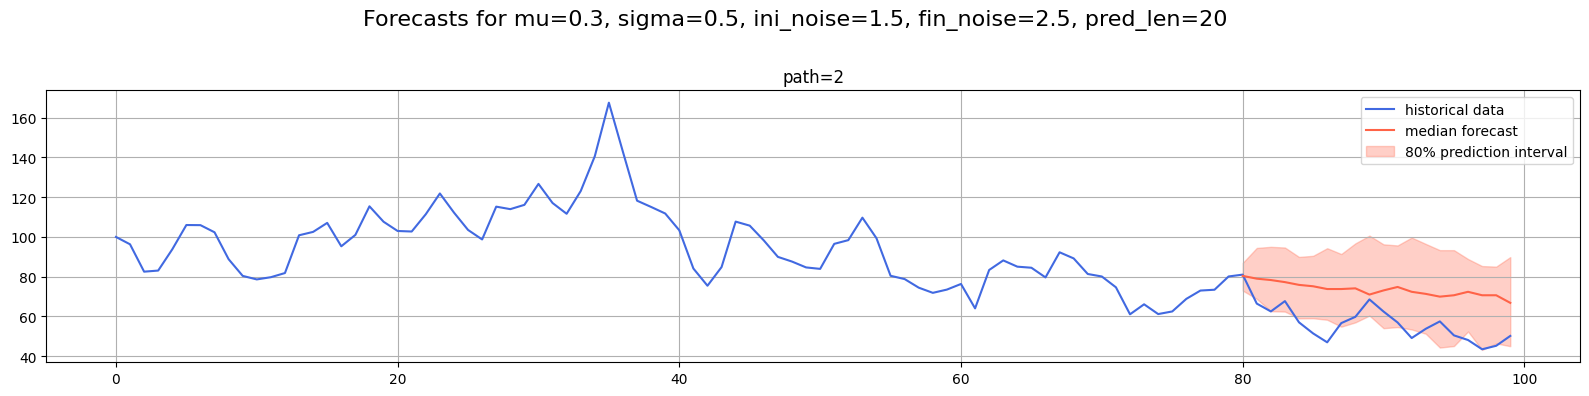

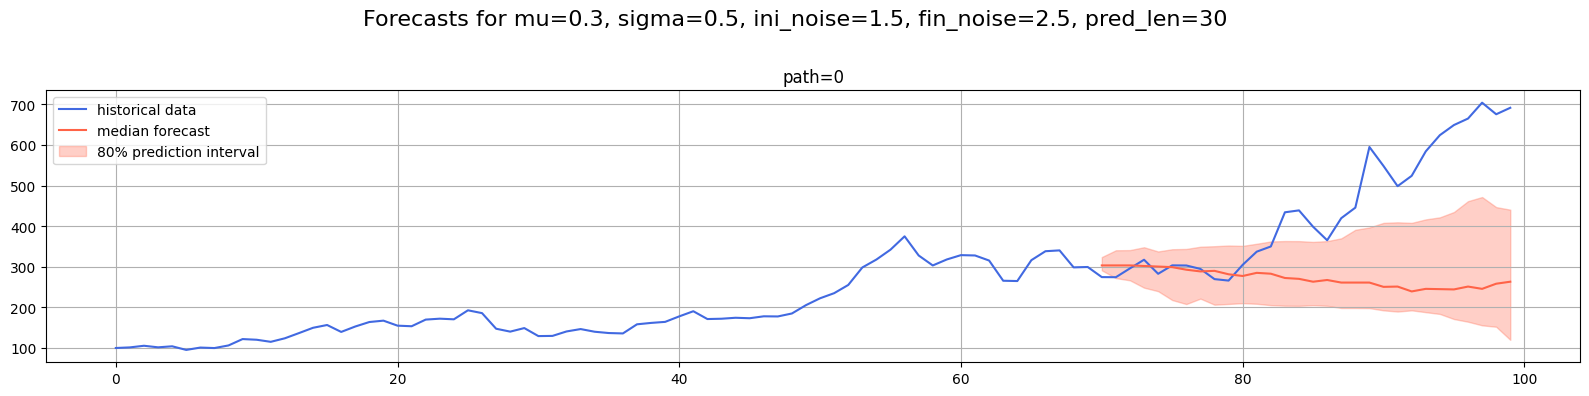

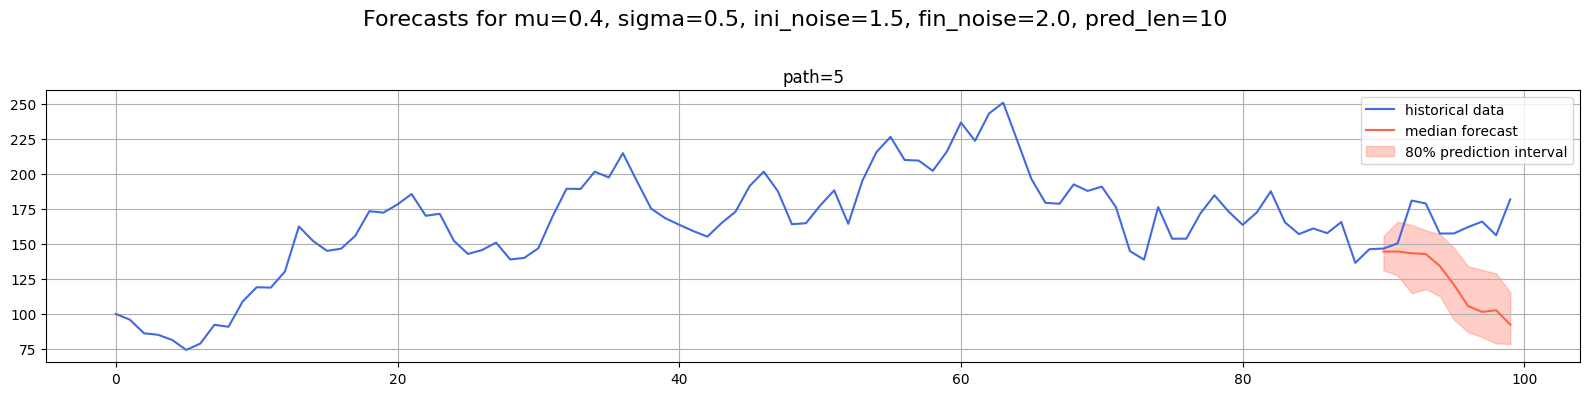

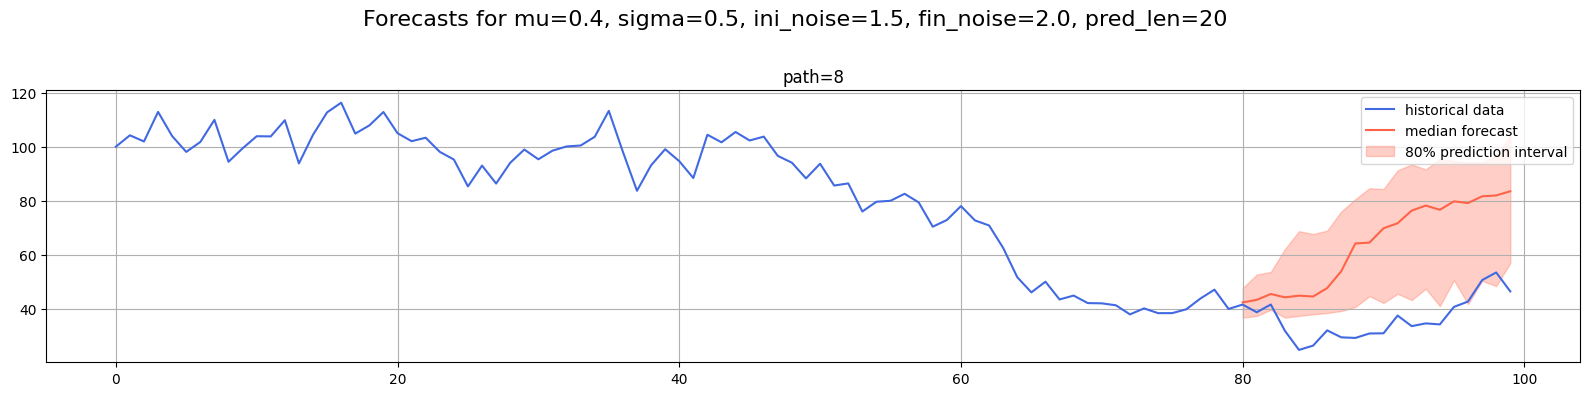

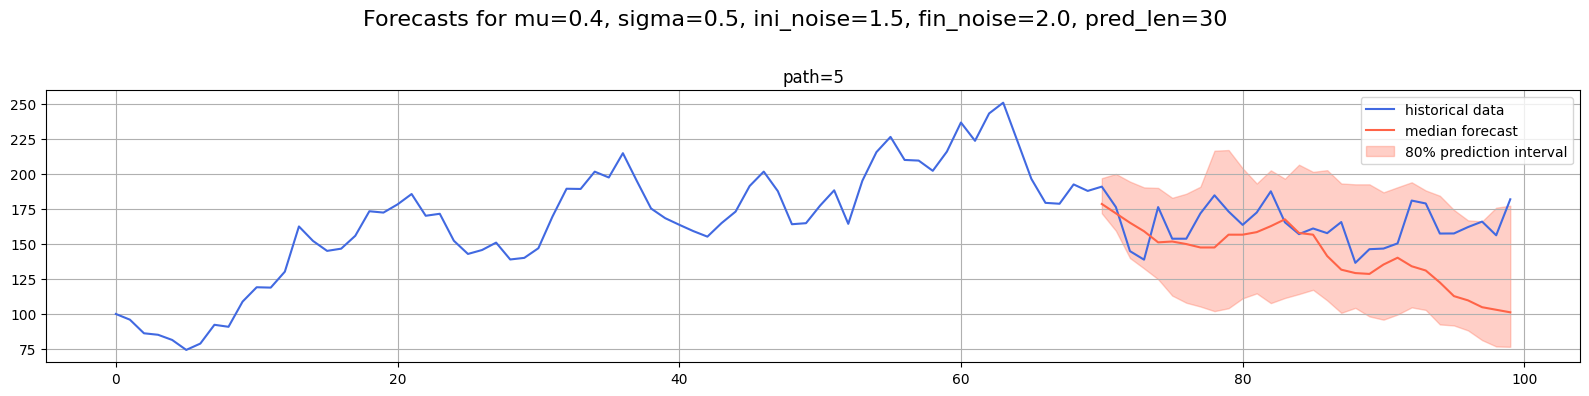

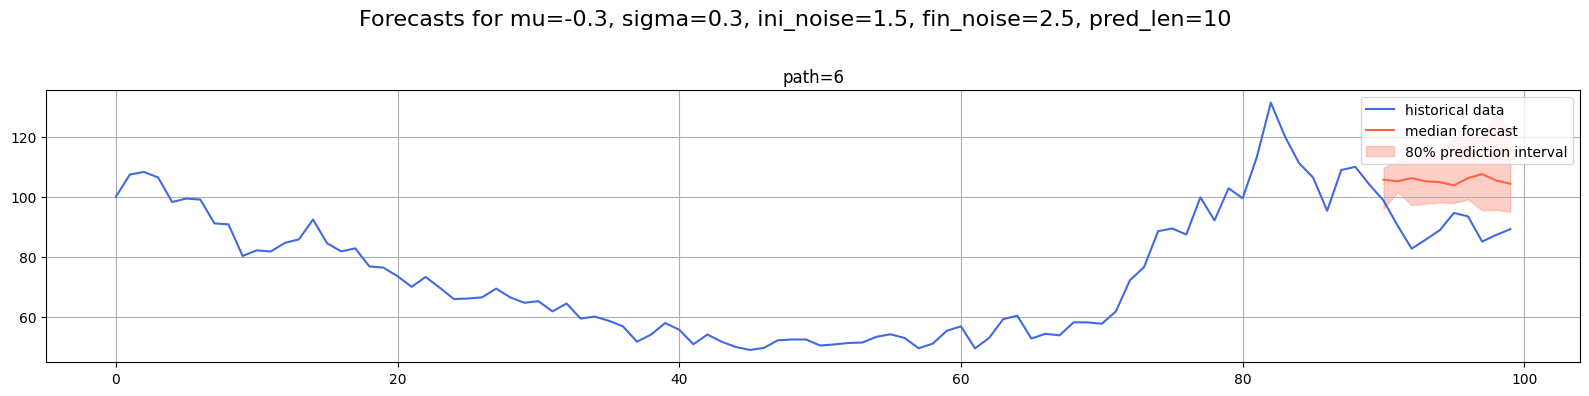

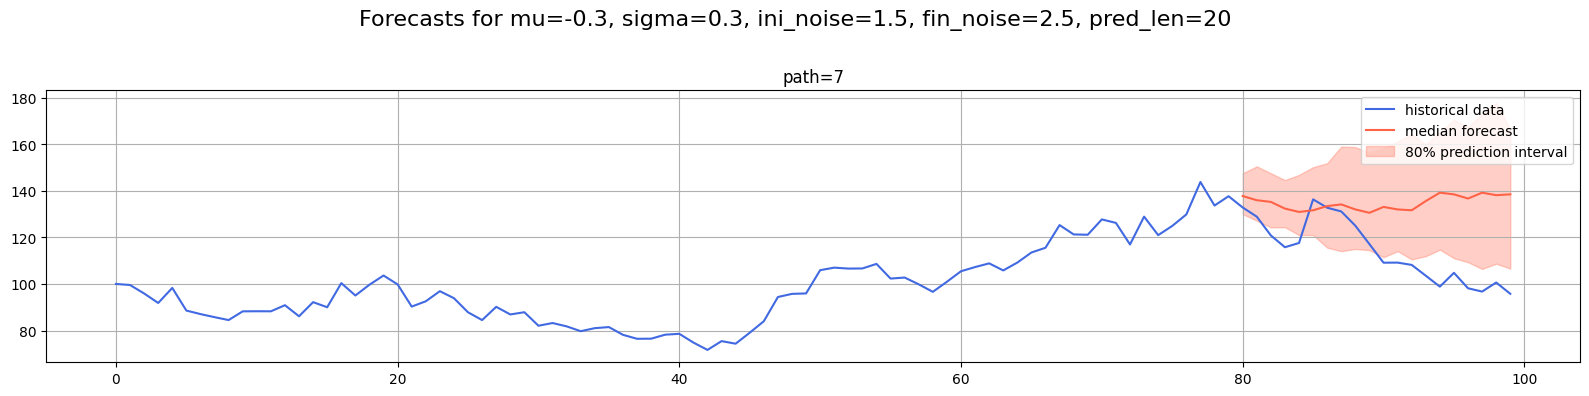

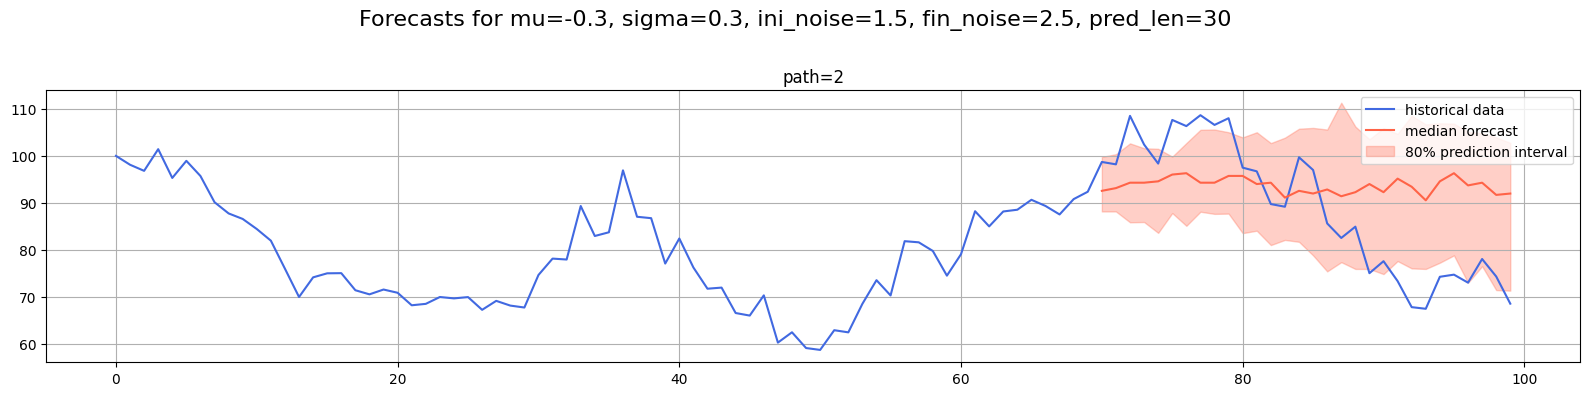

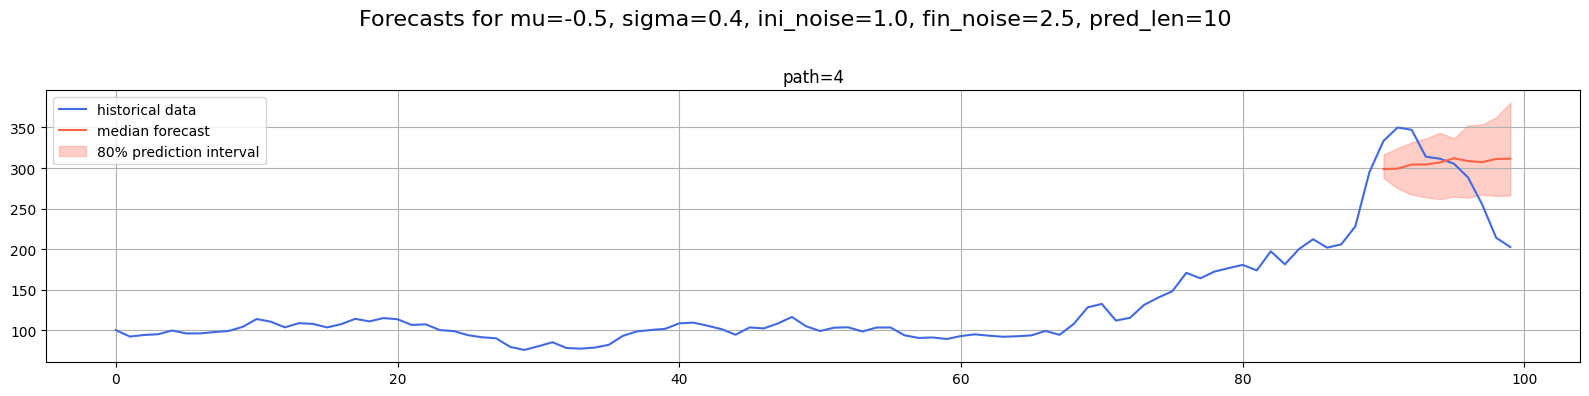

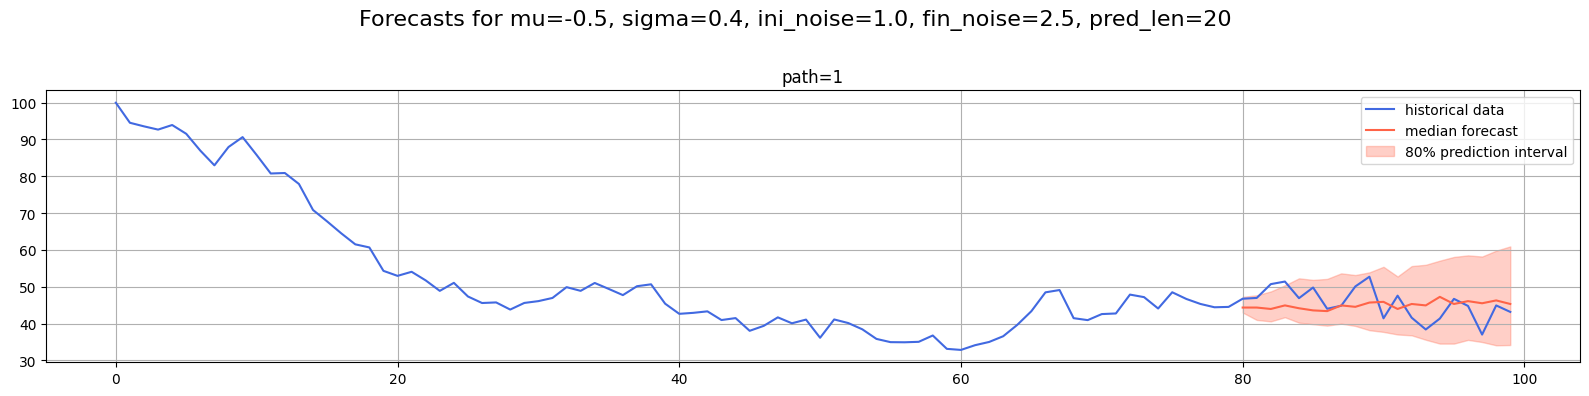

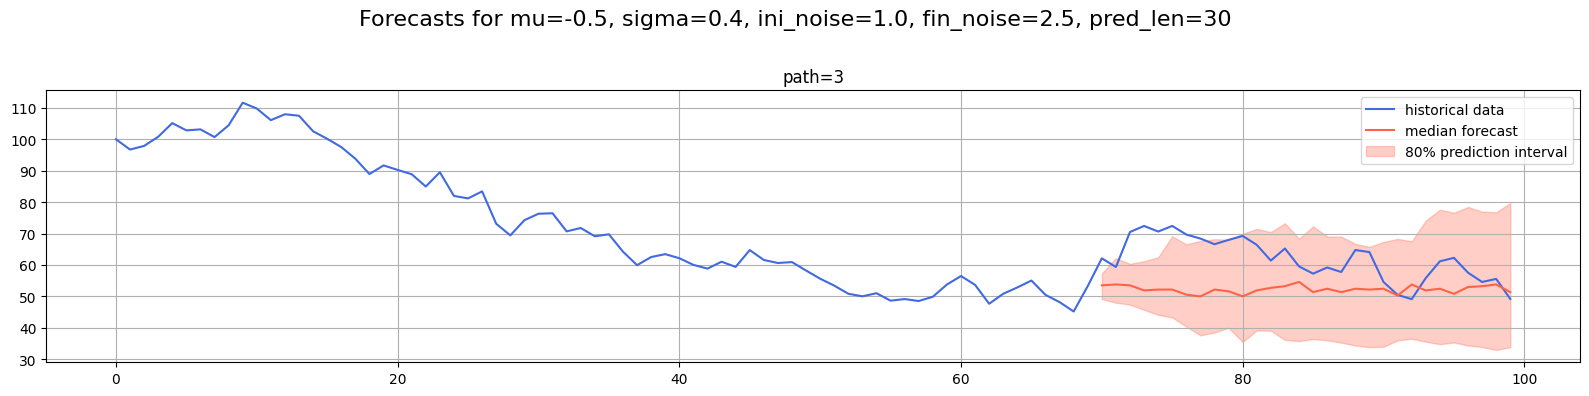

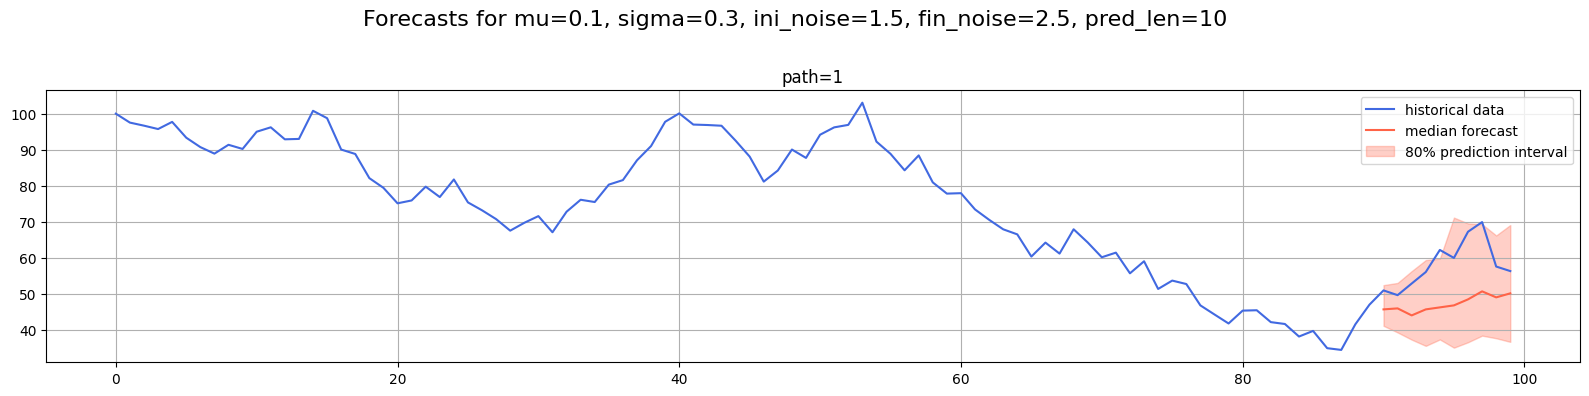

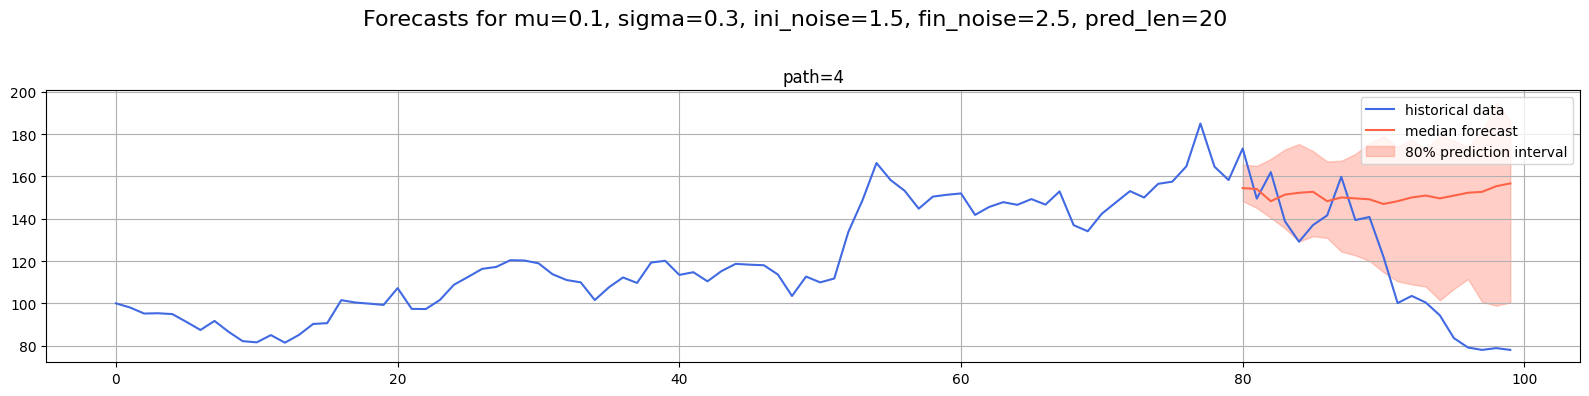

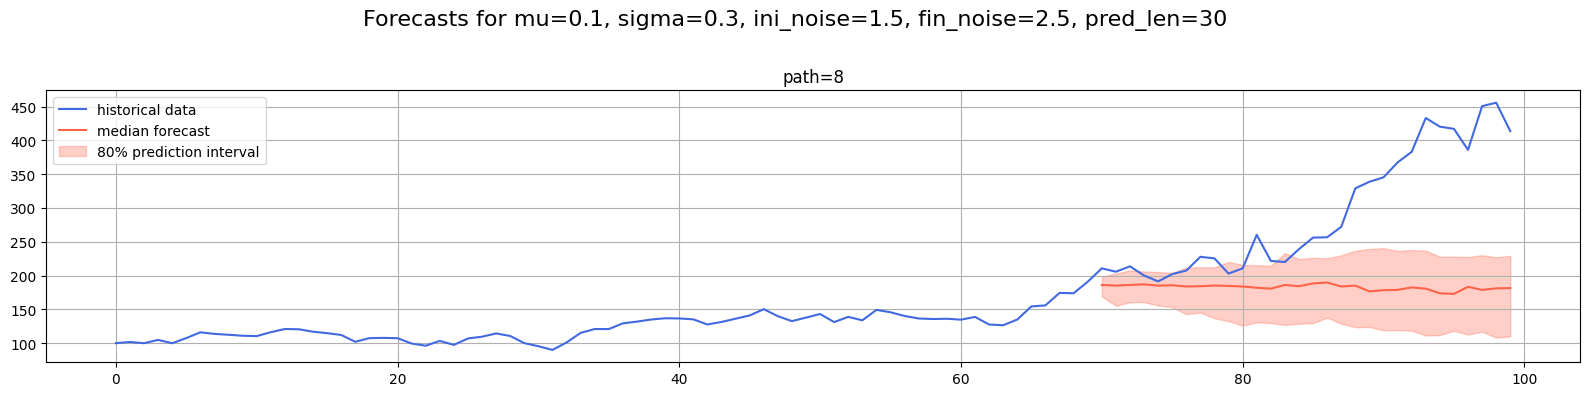

In [59]:
# Iterate over each (mu, sigma, initial_noise_factor, final_noise_factor) combination
for mu, sigma, ini_noise, fin_noise in combinations_as_tuples:
    # Filter the DataFrame for the current combination
    df_filtered_comb = df_gbm[(df_gbm['mu'] == mu) & (df_gbm['sigma'] == sigma) & 
                              (df_gbm['initial_noise_factor'] == ini_noise) & (df_gbm['final_noise_factor'] == fin_noise)]
    
    # Get unique paths for the current combination
    paths = df_filtered_comb['path'].unique()
    
    for forecastlength in prediction_lengths:
        # Calculate MSE for all paths
        for path in paths:
            # Filter the DataFrame for the current path
            df_filtered = df_filtered_comb[df_filtered_comb['path'] == path]
            
            # Extract time points and stock prices
            time_points = [col for col in df_filtered.columns if col.startswith('t_')]
            stock_prices = df_filtered[time_points].values.flatten()
            
            # Generate forecast
            forecast = pipeline.predict(
                context=torch.tensor(stock_prices[:-forecastlength]),
                prediction_length=forecastlength,
                num_samples=30,
            )
            
            # Calculate forecast quantiles
            forecast_index = range(len(stock_prices) - forecastlength, len(stock_prices))
            low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
            
            # Calculate MSE for the current combination, path, and prediction length
            mse = mean_squared_error(stock_prices[-forecastlength:], median)
            
            # Store MSE in the summary dictionary
            key = (mu, sigma, ini_noise, fin_noise, forecastlength)
            if key not in mse_summary:
                mse_summary[key] = []
            mse_summary[key].append(mse)
        
        # Sample some paths to plot
        if (mu, sigma, ini_noise, fin_noise) in sampled_combinations:
            sampled_paths = np.random.choice(paths, size=min(len(paths), 1), replace=False)  # Plot one path for each combination
            
            # Create a new figure for the current combination and prediction length
            plt.figure(figsize=(16, len(sampled_paths) * 4))
            plt.suptitle(f"Forecasts for mu={mu}, sigma={sigma}, ini_noise={ini_noise}, fin_noise={fin_noise}, pred_len={forecastlength}", fontsize=16)
            
            # Initialize subplot index
            subplot_idx = 1
            
            for path in sampled_paths:
                # Filter the DataFrame for the current path
                df_filtered = df_filtered_comb[df_filtered_comb['path'] == path]
                
                # Extract time points and stock prices
                time_points = [col for col in df_filtered.columns if col.startswith('t_')]
                stock_prices = df_filtered[time_points].values.flatten()
                
                # Generate forecast
                forecast = pipeline.predict(
                    context=torch.tensor(stock_prices[:-forecastlength]),
                    prediction_length=forecastlength,
                    num_samples=30,
                )
                
                # Calculate forecast quantiles
                forecast_index = range(len(stock_prices) - forecastlength, len(stock_prices))
                low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
                
                # Plot the results for sampled paths
                plt.subplot(len(sampled_paths), 1, subplot_idx)
                plt.plot(stock_prices, color="royalblue", label="historical data")
                plt.plot(forecast_index, median, color="tomato", label="median forecast")
                plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
                plt.title(f"path={path}")
                plt.legend()
                plt.grid()
                
                # Increment subplot index
                subplot_idx += 1
            
            # Adjust layout and show plot for the current combination and prediction length
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()



In [60]:
# Calculate average MSE for each combination and prediction length
avg_mse_summary = {k: np.mean(v) for k, v in mse_summary.items()}

# Display the summary of MSE
mse_df = pd.DataFrame(avg_mse_summary.items(), columns=['(mu, sigma, ini_noise, fin_noise, pred_len)', 'Average MSE'])
print(mse_df)


    (mu, sigma, ini_noise, fin_noise, pred_len)  Average MSE
0                     (-0.2, 0.4, 1.0, 2.0, 10)   541.673232
1                     (-0.2, 0.4, 1.0, 2.0, 20)   440.032068
2                     (-0.2, 0.4, 1.0, 2.0, 30)   573.709659
3                     (-0.1, 0.3, 1.5, 2.5, 10)   822.195678
4                     (-0.1, 0.3, 1.5, 2.5, 20)  1469.483765
..                                          ...          ...
295                   (-0.3, 0.4, 1.5, 2.5, 20)   605.226413
296                   (-0.3, 0.4, 1.5, 2.5, 30)   646.457906
297                    (0.6, 0.1, 1.0, 2.0, 10)   114.167720
298                    (0.6, 0.1, 1.0, 2.0, 20)    89.438753
299                    (0.6, 0.1, 1.0, 2.0, 30)   236.328662

[300 rows x 2 columns]
